In [1]:
# ============================================================
# Trial13: min_vce-only + Multi-scale ΔVCE + (light) trend/stats features
# - Input is STILL only derived from min_vce (no new sensors)
# - Adds multi-scale deltas: v(t)-v(t-k), k in {1,5,20,50} (configurable)
# - Adds EMA trend features + rolling std feature (configurable)
# - Keeps Trial9 evaluation pack: PH / α–λ / CRA / convergence + paper figures
#
# Folder:
#   ./Trial13/seed_<seed>/best_by_val_norm/...
#   ./Trial13/seed_<seed>/last_epoch/...
#
# Notes:
# - This is a "drop-in" replacement for Trial9 training/eval script.
# - You can later add XAI pack on top of this exactly like Trial12 did.
# ============================================================

import os
import random
from dataclasses import dataclass
from pathlib import Path
from typing import List, Tuple, Dict, Any, Optional

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt


# ============================================================
# 0) Reproducibility
# ============================================================
def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# ============================================================
# 1) Config
# ============================================================
@dataclass
class Config:
    data_dir: str = r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100"
    out_dir: str = r"./Trial13"

    # seeds to sweep
    seeds: Tuple[int, ...] = (9819123, 111, 222, 333, 444)

    # sliding window
    seq_len: int = 100
    stride: int = 5
    pred_horizon: int = 0

    # split by FILE
    train_ratio: float = 0.7
    val_ratio: float = 0.2
    test_ratio: float = 0.1

    # training
    batch_size: int = 512
    epochs: int = 300
    lr: float = 1e-3
    weight_decay: float = 0.0
    patience: int = 30
    grad_clip: float = 1.0

    # model
    hidden_size: int = 512
    num_layers: int = 2
    dropout: float = 0.2

    # data loading
    num_workers: int = 0

    # output controls
    save_figures: bool = True
    max_files_to_plot: Optional[int] = None  # None=all

    # ===========================
    # Trial9-style Evaluation settings
    # ===========================
    alpha: float = 0.20
    ph_consecutive_m: int = 5
    rep_method: str = "mean"
    lambdas: Tuple[float, ...] = (0.2, 0.4, 0.6, 0.8)
    lambda_to_plot: float = 0.6
    eps_rul: float = 1e-8

    # ===========================
    # Trial13: Feature engineering from min_vce ONLY
    # ===========================
    # multi-scale deltas: v(t)-v(t-k)
    delta_steps: Tuple[int, ...] = (1, 5, 20, 50)

    # EMA trend features (recursive): span ~ smoothing strength
    ema_spans: Tuple[int, ...] = (10, 50)

    # rolling std over window (simple, O(T*W) but small W)
    roll_std_window: int = 10

    # add constant-per-window stats replicated across time
    add_window_stats: bool = True
    # window stats: mean, std, slope (linear regression) computed on raw vce in the window


# ============================================================
# 2) Data utils
# ============================================================
def list_csv_files(data_dir: str) -> List[Path]:
    p = Path(data_dir)
    files = sorted([f for f in p.glob("*.csv") if f.is_file()])
    if len(files) == 0:
        raise FileNotFoundError(f"No CSV files found in: {data_dir}")
    return files


def read_one_csv(csv_path: Path) -> Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(csv_path, header=None)
    if df.shape[1] < 2:
        raise ValueError(f"{csv_path.name}: expected at least 2 columns, got {df.shape[1]}")
    vce = df.iloc[:, 0].astype(np.float32).to_numpy()
    rul = df.iloc[:, 1].astype(np.float32).to_numpy()

    if len(vce) != len(rul):
        raise ValueError(f"{csv_path.name}: length mismatch vce={len(vce)}, rul={len(rul)}")
    if len(vce) < 5:
        raise ValueError(f"{csv_path.name}: too short sequence length={len(vce)}")
    return vce, rul


def split_files(
    files: List[Path],
    train_ratio: float,
    val_ratio: float,
    test_ratio: float,
    seed: int
) -> Dict[str, List[Path]]:
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9

    rng = random.Random(seed)
    files_shuffled = files[:]
    rng.shuffle(files_shuffled)

    n = len(files_shuffled)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train_files = files_shuffled[:n_train]
    val_files = files_shuffled[n_train:n_train + n_val]
    test_files = files_shuffled[n_train + n_val:]

    return {"train": train_files, "val": val_files, "test": test_files}


def delta_k(v: np.ndarray, k: int) -> np.ndarray:
    out = np.zeros_like(v, dtype=np.float32)
    if k <= 0:
        return out
    out[k:] = v[k:] - v[:-k]
    return out


def ema(v: np.ndarray, span: int) -> np.ndarray:
    # simple EMA: alpha = 2/(span+1)
    if span <= 1:
        return v.astype(np.float32).copy()
    a = 2.0 / (float(span) + 1.0)
    out = np.zeros_like(v, dtype=np.float32)
    out[0] = v[0]
    for i in range(1, len(v)):
        out[i] = a * v[i] + (1.0 - a) * out[i - 1]
    return out


def rolling_std(v: np.ndarray, w: int) -> np.ndarray:
    # causal-ish rolling std using last w points; for first points, use available prefix
    w = int(w)
    out = np.zeros_like(v, dtype=np.float32)
    for i in range(len(v)):
        j0 = max(0, i - w + 1)
        out[i] = float(np.std(v[j0:i + 1], ddof=0))
    return out


def feature_names(cfg: Config) -> List[str]:
    names = ["min_vce"]
    for k in cfg.delta_steps:
        names.append(f"delta_{k}")
    for s in cfg.ema_spans:
        names.append(f"ema_{s}")
    if cfg.roll_std_window and cfg.roll_std_window > 1:
        names.append(f"rollstd_{cfg.roll_std_window}")
    if cfg.add_window_stats:
        names += ["win_mean", "win_std", "win_slope"]
    return names


def build_features_from_min_vce(vce: np.ndarray, cfg: Config) -> np.ndarray:
    """
    Return X(T,F) features derived ONLY from min_vce.
    """
    feats = [vce.astype(np.float32)]

    # multi-scale deltas
    for k in cfg.delta_steps:
        feats.append(delta_k(vce, int(k)))

    # EMA trends
    for s in cfg.ema_spans:
        feats.append(ema(vce, int(s)))

    # rolling std
    if cfg.roll_std_window and cfg.roll_std_window > 1:
        feats.append(rolling_std(vce, int(cfg.roll_std_window)))

    X = np.stack(feats, axis=1).astype(np.float32)  # (T, F_base)

    # window stats (placeholder here; computed per-window in dataset)
    # We'll append later inside __getitem__ (because stats depend on window segment).
    return X


# ============================================================
# 3) Dataset
# ============================================================
class WindowedRULDatasetNormMinVCE_Trial13(Dataset):
    """
    Returns:
      x: (seq_len, F)
      y_norm: (1,)
      name, start_idx, y_cycles, rul0
    """
    def __init__(
        self,
        file_list: List[Path],
        cfg: Config,
        scaler_x: StandardScaler = None,
        fit_scaler: bool = False,
    ):
        self.file_list = file_list
        self.cfg = cfg
        self.seq_len = cfg.seq_len
        self.stride = cfg.stride
        self.pred_horizon = cfg.pred_horizon
        self.scaler_x = scaler_x if scaler_x is not None else StandardScaler()

        # store: (name, Xbase(T,Fbase), vce(T,), rul(T,), rul0)
        self.series: List[Tuple[str, np.ndarray, np.ndarray, np.ndarray, float]] = []
        for fp in self.file_list:
            vce, rul = read_one_csv(fp)
            rul0 = float(rul[0])
            if rul0 <= 0:
                raise ValueError(f"{fp.name}: RUL0 must be > 0, got {rul0}")

            Xbase = build_features_from_min_vce(vce, cfg).astype(np.float32)
            self.series.append((fp.name, Xbase, vce.astype(np.float32), rul.astype(np.float32), rul0))

        # Fit scaler on TRAIN windows (recommended):
        # We fit using ALL timesteps of ALL files here (same as your previous approach),
        # BUT with window-stats appended we need a strategy.
        #
        # Strategy:
        # - Fit scaler on base features only + append "typical" window stats computed from sliding windows
        #   => easiest: build a sampled set of windows and gather per-timestep feature rows.
        #
        # To keep it simple & stable:
        # - If add_window_stats=False: fit on all timesteps base features (fast).
        # - If add_window_stats=True: sample up to N windows across files and fit on resulting full features.
        if fit_scaler:
            if not cfg.add_window_stats:
                all_x = np.concatenate([Xbase for _, Xbase, _, _, _ in self.series], axis=0)
                self.scaler_x.fit(all_x)
            else:
                # sample windows to fit scaler with full feature dimension
                rng = np.random.RandomState(0)
                rows = []
                max_windows_for_scaler = 5000  # reasonable cap
                for (_name, Xbase, vce_raw, _rul, _rul0) in self.series:
                    T = Xbase.shape[0]
                    last_start = T - (self.seq_len + self.pred_horizon)
                    if last_start < 0:
                        continue
                    starts = list(range(0, last_start + 1, self.stride))
                    if len(starts) == 0:
                        continue
                    # subsample per file
                    if len(starts) > 200:
                        starts = rng.choice(starts, size=200, replace=False).tolist()
                    for s in starts:
                        xw = Xbase[s:s + self.seq_len, :]  # (L,Fbase)
                        # window stats from raw vce segment
                        seg = vce_raw[s:s + self.seq_len]
                        wmean = float(np.mean(seg))
                        wstd = float(np.std(seg, ddof=0))
                        # slope via least squares on t
                        t = np.arange(self.seq_len, dtype=np.float32)
                        # slope = cov(t,seg)/var(t)
                        denom = float(np.var(t) + 1e-12)
                        slope = float(np.cov(t, seg, ddof=0)[0, 1] / denom) if denom > 0 else 0.0
                        stats = np.array([wmean, wstd, slope], dtype=np.float32).reshape(1, 3)
                        stats_rep = np.repeat(stats, repeats=self.seq_len, axis=0)
                        xfull = np.concatenate([xw, stats_rep], axis=1)  # (L,F)
                        rows.append(xfull)
                        if len(rows) >= max_windows_for_scaler:
                            break
                    if len(rows) >= max_windows_for_scaler:
                        break
                if len(rows) == 0:
                    raise ValueError("Scaler fitting failed: no windows sampled. Check seq_len/stride.")
                fit_mat = np.concatenate(rows, axis=0)
                self.scaler_x.fit(fit_mat)

        # window index
        self.index: List[Tuple[int, int]] = []
        for fi, (_name, Xbase, _vce, _rul, _rul0) in enumerate(self.series):
            T = Xbase.shape[0]
            last_start = T - (self.seq_len + self.pred_horizon)
            if last_start < 0:
                continue
            for s in range(0, last_start + 1, self.stride):
                self.index.append((fi, s))

        if len(self.index) == 0:
            raise ValueError("No windows were created. Check seq_len/pred_horizon vs file lengths.")

    def __len__(self) -> int:
        return len(self.index)

    def __getitem__(self, idx: int):
        fi, s = self.index[idx]
        name, Xbase, vce_raw, rul, rul0 = self.series[fi]

        x = Xbase[s:s + self.seq_len, :]  # (L,Fbase)

        if self.cfg.add_window_stats:
            seg = vce_raw[s:s + self.seq_len]
            wmean = float(np.mean(seg))
            wstd = float(np.std(seg, ddof=0))
            t = np.arange(self.seq_len, dtype=np.float32)
            denom = float(np.var(t) + 1e-12)
            slope = float(np.cov(t, seg, ddof=0)[0, 1] / denom) if denom > 0 else 0.0
            stats = np.array([wmean, wstd, slope], dtype=np.float32).reshape(1, 3)
            stats_rep = np.repeat(stats, repeats=self.seq_len, axis=0)
            x = np.concatenate([x, stats_rep], axis=1).astype(np.float32)  # (L,F)

        y_idx = s + self.seq_len - 1 + self.pred_horizon
        y_cycles = float(rul[y_idx])
        y_norm = np.array([y_cycles / rul0], dtype=np.float32)

        x = self.scaler_x.transform(x).astype(np.float32)

        return (
            torch.from_numpy(x),
            torch.from_numpy(y_norm),
            name,
            torch.tensor(s, dtype=torch.long),
            torch.tensor(y_cycles, dtype=torch.float32),
            torch.tensor(rul0, dtype=torch.float32),
        )


# ============================================================
# 4) Model
# ============================================================
class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout: float):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.head(last)


# ============================================================
# 5) Basic Eval + Save window-level predictions
# ============================================================
@torch.no_grad()
def evaluate_basic(model, loader, device) -> Dict[str, float]:
    model.eval()

    mae_norm_list, mse_norm_list = [], []
    mae_cyc_list, mse_cyc_list = [], []

    for x, y_norm, _name, _s, y_cycles, rul0 in loader:
        x = x.to(device)
        y_norm = y_norm.to(device)
        y_cycles = y_cycles.to(device).view(-1, 1)
        rul0 = rul0.to(device).view(-1, 1)

        pred_norm = model(x)

        err_norm = pred_norm - y_norm
        mae_norm_list.append(torch.mean(torch.abs(err_norm)).item())
        mse_norm_list.append(torch.mean(err_norm ** 2).item())

        pred_cycles = pred_norm * rul0
        err_cyc = pred_cycles - y_cycles
        mae_cyc_list.append(torch.mean(torch.abs(err_cyc)).item())
        mse_cyc_list.append(torch.mean(err_cyc ** 2).item())

    return {
        "mae_norm": float(np.mean(mae_norm_list)) if mae_norm_list else float("nan"),
        "rmse_norm": float(np.sqrt(np.mean(mse_norm_list))) if mse_norm_list else float("nan"),
        "mae_cycles": float(np.mean(mae_cyc_list)) if mae_cyc_list else float("nan"),
        "rmse_cycles": float(np.sqrt(np.mean(mse_cyc_list))) if mse_cyc_list else float("nan"),
    }


@torch.no_grad()
def save_predictions_windows_csv(model, loader, device, out_csv: str, seq_len: int) -> None:
    model.eval()
    rows: List[Dict[str, Any]] = []

    for x, y_norm, name, s, y_cycles, rul0 in loader:
        x = x.to(device)
        y_norm = y_norm.to(device)
        y_cycles = y_cycles.to(device).view(-1, 1)
        rul0 = rul0.to(device).view(-1, 1)

        pred_norm = model(x)
        pred_cycles = pred_norm * rul0

        pred_norm_np = pred_norm.cpu().numpy().reshape(-1)
        y_norm_np = y_norm.cpu().numpy().reshape(-1)
        pred_cyc_np = pred_cycles.cpu().numpy().reshape(-1)
        y_cyc_np = y_cycles.cpu().numpy().reshape(-1)

        rul0_np = rul0.cpu().numpy().reshape(-1)
        s_np = s.cpu().numpy().reshape(-1)
        name_list = list(name)

        for i in range(len(pred_norm_np)):
            rows.append({
                "file": name_list[i],
                "start_idx": int(s_np[i]),
                "cycle": int(s_np[i] + (seq_len - 1)),
                "rul0": float(rul0_np[i]),
                "RUL_true": float(y_cyc_np[i]),
                "RUL_pred": float(pred_cyc_np[i]),
                "RUL_true_norm": float(y_norm_np[i]),
                "RUL_pred_norm": float(pred_norm_np[i]),
            })

    pd.DataFrame(rows).to_csv(out_csv, index=False)


# ============================================================
# 6) Window -> Cycle sequence (mean representative)
# ============================================================
def windows_to_cycle_sequence_mean(windows_csv: str) -> pd.DataFrame:
    dfw = pd.read_csv(windows_csv)
    if dfw.empty:
        raise ValueError(f"Empty windows csv: {windows_csv}")

    g = dfw.groupby(["file", "cycle"], as_index=False).agg(
        rul0=("rul0", "first"),
        RUL_true=("RUL_true", "mean"),
        RUL_pred=("RUL_pred", "mean"),
        n_windows=("RUL_pred", "count"),
    )
    return g


# ============================================================
# 7) Prognostics metrics (same as Trial9)
# ============================================================
def compute_metrics_for_one_file(
    df_seq_one_file: pd.DataFrame,
    seq_len: int,
    alpha: float,
    ph_consecutive_m: int,
    lambdas: Tuple[float, ...],
    eps_rul: float,
) -> Tuple[pd.DataFrame, Dict[str, Any]]:

    df = df_seq_one_file.sort_values("cycle").reset_index(drop=True).copy()

    t_s = seq_len - 1
    last_cycle = int(df["cycle"].max())
    EOL_true = last_cycle + 1
    t_e = EOL_true - 1

    df_eval = df[(df["cycle"] >= t_s) & (df["cycle"] <= t_e)].copy()
    df_eval.reset_index(drop=True, inplace=True)

    if df_eval.empty:
        summary = {
            "t_s": t_s, "t_e": t_e, "EOL_true": EOL_true,
            "PH": np.nan, "t_PH_start": np.nan,
            "CRA": np.nan, "Convergence_cycles": np.nan,
        }
        for lam in lambdas:
            summary[f"t_lambda_{lam:.2f}"] = np.nan
            summary[f"alpha_lambda_ok_{lam:.2f}"] = np.nan
        return df_eval, summary

    denom = np.maximum(np.abs(df_eval["RUL_true"].values), eps_rul)
    rel_err = np.abs(df_eval["RUL_true"].values - df_eval["RUL_pred"].values) / denom
    RA = 1.0 - rel_err

    df_eval["rel_err"] = rel_err
    df_eval["RA"] = RA
    df_eval["in_alpha"] = df_eval["rel_err"] <= alpha

    CRA = float(np.mean(df_eval["RA"].values))

    flags = df_eval["in_alpha"].values.astype(np.int32)
    t_PH_start = np.nan
    if len(flags) >= ph_consecutive_m:
        run = 0
        for i, ok in enumerate(flags):
            if ok:
                run += 1
                if run >= ph_consecutive_m:
                    start_i = i - ph_consecutive_m + 1
                    t_PH_start = int(df_eval.loc[start_i, "cycle"])
                    break
            else:
                run = 0

    if np.isfinite(t_PH_start):
        PH = float(EOL_true - t_PH_start)
        Convergence_cycles = float(t_PH_start - t_s)
    else:
        PH = np.nan
        Convergence_cycles = np.nan

    rul0 = float(df_eval["rul0"].iloc[0])
    lam_results = {}
    for lam in lambdas:
        target_rul = (1.0 - float(lam)) * rul0
        idx = int(np.argmin(np.abs(df_eval["RUL_true"].values - target_rul)))
        t_lam = int(df_eval.loc[idx, "cycle"])
        ok = bool(df_eval.loc[idx, "rel_err"] <= alpha)

        lam_results[f"t_lambda_{lam:.2f}"] = t_lam
        lam_results[f"alpha_lambda_ok_{lam:.2f}"] = int(ok)

    summary = {
        "t_s": int(t_s),
        "t_e": int(t_e),
        "EOL_true": int(EOL_true),
        "alpha": float(alpha),
        "ph_consecutive_m": int(ph_consecutive_m),
        "CRA": CRA,
        "t_PH_start": t_PH_start if np.isfinite(t_PH_start) else np.nan,
        "PH": PH,
        "Convergence_cycles": Convergence_cycles,
        **lam_results
    }
    return df_eval, summary


def compute_metrics_from_windows_csv(
    windows_csv: str,
    seq_len: int,
    alpha: float,
    ph_consecutive_m: int,
    lambdas: Tuple[float, ...],
    eps_rul: float,
    out_dir: str,
    split_name: str,
) -> Tuple[str, str]:

    os.makedirs(out_dir, exist_ok=True)

    df_seq = windows_to_cycle_sequence_mean(windows_csv)
    seq_path = os.path.join(out_dir, f"{split_name}_cycle_sequence_mean.csv")
    df_seq.to_csv(seq_path, index=False)

    rows = []
    for f in df_seq["file"].unique():
        sub = df_seq[df_seq["file"] == f].copy()
        _df_eval, summary = compute_metrics_for_one_file(
            df_seq_one_file=sub,
            seq_len=seq_len,
            alpha=alpha,
            ph_consecutive_m=ph_consecutive_m,
            lambdas=lambdas,
            eps_rul=eps_rul,
        )
        summary["file"] = f
        rows.append(summary)

    dfm = pd.DataFrame(rows)
    metrics_path = os.path.join(out_dir, f"{split_name}_prognostics_metrics_per_file.csv")
    dfm.to_csv(metrics_path, index=False)

    return seq_path, metrics_path


# ============================================================
# 8) Plotters (same as Trial9 + your fixes)
# ============================================================
def _safe_name(s: str) -> str:
    return s.replace("/", "_").replace("\\", "_").replace(":", "_")


def plot_alpha_ph(
    df_eval: pd.DataFrame,
    file_name: str,
    title: str,
    alpha: float,
    PH_start: Optional[float],
    out_path: str,
    dpi: int = 200,
) -> None:
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.figure()

    x = df_eval["cycle"].values
    y_true = df_eval["RUL_true"].values
    y_pred = df_eval["RUL_pred"].values

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.plot(x, y_true, color="k", label="True (cycles)")
    plt.plot(x, y_pred, color="r", label="Prediction (cycles)")
    plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} alpha accuracy zone")
    plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} alpha accuracy zone")

    if PH_start is not None and np.isfinite(PH_start):
        plt.axvline(int(PH_start), color="g", linestyle="-.", label="PH start")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title}\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close()


def plot_alpha_lambda(
    df_eval: pd.DataFrame,
    file_name: str,
    title: str,
    alpha: float,
    lambda_to_plot: float,
    t_lambda: Optional[int],
    out_path: str,
    dpi: int = 200,
) -> None:
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].values
    y_true = df_eval["RUL_true"].values
    y_pred = df_eval["RUL_pred"].values

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.figure()
    plt.plot(x, y_true, color="k", label="True (cycles)")
    plt.plot(x, y_pred, color="r", label="Prediction (cycles)")

    if t_lambda is not None and np.isfinite(t_lambda):
        t_lambda = int(t_lambda)
        plt.axvline(t_lambda, linestyle=":", color="g", label=f"t_λ (λ={lambda_to_plot:.2f})")
        mask = x >= t_lambda
        if np.any(mask):
            plt.plot(x[mask], upper[mask], color="b", linestyle="--", label=f"+{alpha:.2f} alpha–lambda zone")
            plt.plot(x[mask], lower[mask], color="b", linestyle="--", label=f"-{alpha:.2f} alpha–lambda zone")
        else:
            plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} α zone")
            plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} α zone")
    else:
        plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} α zone")
        plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} α zone")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title}\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close()


def make_paper_figures_for_split(
    cycle_seq_csv: str,
    metrics_per_file_csv: str,
    out_fig_dir: str,
    title_prefix: str,
    alpha: float,
    lambda_to_plot: float,
    max_files: Optional[int] = None,
    dpi: int = 200,
) -> None:
    df_seq = pd.read_csv(cycle_seq_csv)
    dfm = pd.read_csv(metrics_per_file_csv)

    files = df_seq["file"].unique().tolist()
    if max_files is not None:
        files = files[:max_files]

    os.makedirs(out_fig_dir, exist_ok=True)

    lam_key = f"t_lambda_{lambda_to_plot:.2f}"

    for f in files:
        sub = df_seq[df_seq["file"] == f].sort_values("cycle").copy()
        mrow = dfm[dfm["file"] == f]
        if mrow.empty:
            continue
        mrow = mrow.iloc[0].to_dict()

        t_s = int(mrow["t_s"])
        t_e = int(mrow["t_e"])
        PH_start = mrow.get("t_PH_start", np.nan)

        df_eval = sub[(sub["cycle"] >= t_s) & (sub["cycle"] <= t_e)].copy()
        if df_eval.empty:
            continue

        t_lambda = None
        if lam_key in mrow and np.isfinite(mrow[lam_key]):
            t_lambda = int(mrow[lam_key])

        safe = _safe_name(f)

        out1 = os.path.join(out_fig_dir, f"FIG1_alpha_PH__{safe}.png")
        plot_alpha_ph(
            df_eval=df_eval,
            file_name=f,
            title=f"{title_prefix} | α+PH",
            alpha=alpha,
            PH_start=PH_start if np.isfinite(PH_start) else None,
            out_path=out1,
            dpi=dpi,
        )

        out2 = os.path.join(out_fig_dir, f"FIG2_alpha_lambda__lam{lambda_to_plot:.2f}__{safe}.png")
        plot_alpha_lambda(
            df_eval=df_eval,
            file_name=f,
            title=f"{title_prefix} | α–λ (λ={lambda_to_plot:.2f})",
            alpha=alpha,
            lambda_to_plot=lambda_to_plot,
            t_lambda=t_lambda,
            out_path=out2,
            dpi=dpi,
        )


# ============================================================
# 9) One seed run (train + export best/last + Trial9 metrics)
# ============================================================
def run_one_seed(cfg: Config, seed: int) -> Dict[str, Any]:
    set_seed(seed)

    seed_dir = os.path.join(cfg.out_dir, f"seed_{seed}")
    os.makedirs(seed_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n==============================")
    print(f"[SEED {seed}] device={device}")
    print(f"[SEED {seed}] out={seed_dir}")
    print(f"==============================")

    # split
    files = list_csv_files(cfg.data_dir)
    splits = split_files(files, cfg.train_ratio, cfg.val_ratio, cfg.test_ratio, seed)

    # save split lists
    for k in ["train", "val", "test"]:
        pd.Series([p.name for p in splits[k]]).to_csv(
            os.path.join(seed_dir, f"{k}_files.csv"), index=False, header=False
        )

    # datasets (fit scaler on train only)
    scaler_x = StandardScaler()
    train_ds = WindowedRULDatasetNormMinVCE_Trial13(
        splits["train"], cfg, scaler_x=scaler_x, fit_scaler=True
    )
    val_ds = WindowedRULDatasetNormMinVCE_Trial13(
        splits["val"], cfg, scaler_x=train_ds.scaler_x, fit_scaler=False
    )
    test_ds = WindowedRULDatasetNormMinVCE_Trial13(
        splits["test"], cfg, scaler_x=train_ds.scaler_x, fit_scaler=False
    )

    feat_list = feature_names(cfg)
    pd.DataFrame({
        "feature": feat_list,
        "mean": train_ds.scaler_x.mean_.ravel(),
        "std": np.sqrt(train_ds.scaler_x.var_).ravel(),
    }).to_csv(os.path.join(seed_dir, "scaler_x_mean_std.csv"), index=False)

    # loaders
    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
    val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

    train_eval = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
    val_eval = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
    test_eval = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

    # model
    input_size = len(feat_list)
    model = LSTMRegressor(
        input_size=input_size,
        hidden_size=cfg.hidden_size,
        num_layers=cfg.num_layers,
        dropout=cfg.dropout,
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    best_by_val_norm = float("inf")
    best_path = os.path.join(seed_dir, "best_by_val_norm.pt")
    last_path = os.path.join(seed_dir, "last_epoch.pt")

    history: List[Dict[str, Any]] = []
    bad_epochs = 0

    for epoch in range(1, cfg.epochs + 1):
        model.train()
        losses = []

        for x, y_norm, *_ in train_loader:
            x = x.to(device)
            y_norm = y_norm.to(device)

            optimizer.zero_grad()
            pred_norm = model(x)
            loss = criterion(pred_norm, y_norm)
            loss.backward()

            if cfg.grad_clip and cfg.grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)

            optimizer.step()
            losses.append(loss.item())

        train_mse_norm = float(np.mean(losses)) if losses else float("nan")
        val_metrics = evaluate_basic(model, val_loader, device)

        history.append({
            "epoch": epoch,
            "train_mse_norm": train_mse_norm,
            "val_rmse_norm": val_metrics["rmse_norm"],
            "val_mae_norm": val_metrics["mae_norm"],
            "val_rmse_cycles": val_metrics["rmse_cycles"],
            "val_mae_cycles": val_metrics["mae_cycles"],
        })

        if val_metrics["rmse_norm"] < best_by_val_norm:
            best_by_val_norm = val_metrics["rmse_norm"]
            bad_epochs = 0
            torch.save(model.state_dict(), best_path)
        else:
            bad_epochs += 1

        if epoch == 1 or epoch % 10 == 0:
            print(
                f"[SEED {seed}] [{epoch:03d}/{cfg.epochs}] "
                f"train_mse_norm={train_mse_norm:.6f} | "
                f"val_rmse_norm={val_metrics['rmse_norm']:.6f} | "
                f"val_mae_cycles={val_metrics['mae_cycles']:.3f} | "
                f"best_val_rmse_norm={best_by_val_norm:.6f}"
            )

        if bad_epochs >= cfg.patience:
            print(f"[SEED {seed}] Early stopping at epoch {epoch}.")
            break

    pd.DataFrame(history).to_csv(os.path.join(seed_dir, "history.csv"), index=False)
    torch.save(model.state_dict(), last_path)

    def export_ckpt(tag: str, ckpt_path: str) -> Dict[str, Any]:
        sub_dir = os.path.join(seed_dir, tag)
        os.makedirs(sub_dir, exist_ok=True)

        model.load_state_dict(torch.load(ckpt_path, map_location=device))
        model.eval()

        tr = evaluate_basic(model, train_eval, device)
        va = evaluate_basic(model, val_eval, device)
        te = evaluate_basic(model, test_eval, device)

        for split_name, loader in [("train", train_eval), ("val", val_eval), ("test", test_eval)]:
            win_csv = os.path.join(sub_dir, f"{split_name}_predictions_windows.csv")
            save_predictions_windows_csv(model, loader, device, win_csv, seq_len=cfg.seq_len)

            seq_csv, metrics_csv = compute_metrics_from_windows_csv(
                windows_csv=win_csv,
                seq_len=cfg.seq_len,
                alpha=cfg.alpha,
                ph_consecutive_m=cfg.ph_consecutive_m,
                lambdas=cfg.lambdas,
                eps_rul=cfg.eps_rul,
                out_dir=sub_dir,
                split_name=split_name,
            )

            if cfg.save_figures:
                fig_dir = os.path.join(sub_dir, "paper_figures", split_name)
                make_paper_figures_for_split(
                    cycle_seq_csv=seq_csv,
                    metrics_per_file_csv=metrics_csv,
                    out_fig_dir=fig_dir,
                    title_prefix=f"SEED {seed} | {tag.upper()} | {split_name}",
                    alpha=cfg.alpha,
                    lambda_to_plot=cfg.lambda_to_plot,
                    max_files=cfg.max_files_to_plot,
                )

        ms = {
            "seed": seed,
            "checkpoint": tag,
            "train_rmse_cycles": tr["rmse_cycles"],
            "train_mae_cycles": tr["mae_cycles"],
            "train_rmse_norm": tr["rmse_norm"],
            "train_mae_norm": tr["mae_norm"],
            "val_rmse_cycles": va["rmse_cycles"],
            "val_mae_cycles": va["mae_cycles"],
            "val_rmse_norm": va["rmse_norm"],
            "val_mae_norm": va["mae_norm"],
            "test_rmse_cycles": te["rmse_cycles"],
            "test_mae_cycles": te["mae_cycles"],
            "test_rmse_norm": te["rmse_norm"],
            "test_mae_norm": te["mae_norm"],
            "stopped_epoch": history[-1]["epoch"] if len(history) else None,
            "best_val_rmse_norm": best_by_val_norm,
            "alpha": cfg.alpha,
            "ph_consecutive_m": cfg.ph_consecutive_m,
            "rep_method": cfg.rep_method,
            "lambdas": str(cfg.lambdas),
            "lambda_to_plot": cfg.lambda_to_plot,
            "feature_dim": input_size,
            "features": ",".join(feature_names(cfg)),
        }
        pd.DataFrame([ms]).to_csv(os.path.join(sub_dir, "metrics_summary.csv"), index=False)

        print(f"[SEED {seed}] {tag}: TEST mae_cycles={te['mae_cycles']:.3f} | rmse_cycles={te['rmse_cycles']:.3f} | rmse_norm={te['rmse_norm']:.6f}")
        return ms

    ms_best = export_ckpt("best_by_val_norm", best_path)
    ms_last = export_ckpt("last_epoch", last_path)

    return {"seed": seed, "seed_dir": seed_dir, "best": ms_best, "last": ms_last}


# ============================================================
# 10) Seed sweep + global comparison
# ============================================================
def summarize_across_seeds(cfg: Config, results: List[Dict[str, Any]]) -> None:
    rows = []
    for r in results:
        rows.append(r["best"])
        rows.append(r["last"])

    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(cfg.out_dir, "summary_across_seeds.csv"), index=False)

    def _isfinite(x: Any) -> bool:
        try:
            return bool(np.isfinite(float(x)))
        except Exception:
            return False

    def win_rate(metric: str) -> Dict[str, Any]:
        wins_last = 0
        wins_best = 0
        ties = 0
        diffs = []

        for r in results:
            b = r["best"][metric]
            l = r["last"][metric]
            if _isfinite(b) and _isfinite(l):
                diffs.append(float(l) - float(b))
                if float(l) < float(b):
                    wins_last += 1
                elif float(b) < float(l):
                    wins_best += 1
                else:
                    ties += 1

        return {
            "metric": metric,
            "wins_last": wins_last,
            "wins_best": wins_best,
            "ties": ties,
            "mean(last-best)": float(np.mean(diffs)) if diffs else float("nan"),
            "std(last-best)": float(np.std(diffs)) if diffs else float("nan"),
        }

    metrics = ["test_mae_cycles", "test_rmse_cycles", "test_mae_norm", "test_rmse_norm"]
    wr = [win_rate(m) for m in metrics]
    pd.DataFrame(wr).to_csv(os.path.join(cfg.out_dir, "win_rate_summary.csv"), index=False)

    lines = []
    lines.append("=== WIN-RATE SUMMARY (TEST; lower is better) ===")
    for row in wr:
        lines.append(
            f"- {row['metric']}: last wins={row['wins_last']}, best wins={row['wins_best']}, ties={row['ties']} | "
            f"mean(last-best)={row['mean(last-best)']:.6f}, std(last-best)={row['std(last-best)']:.6f}"
        )

    agg = df.groupby("checkpoint")[metrics].agg(["mean", "std"])
    lines.append("\n=== MEAN ± STD across seeds (TEST) ===")
    lines.append(str(agg))

    with open(os.path.join(cfg.out_dir, "win_rate_summary.txt"), "w", encoding="utf-8") as f:
        f.write("\n".join(lines))

    print("\n".join(lines))
    print("\nSaved:")
    print(" -", os.path.join(cfg.out_dir, "summary_across_seeds.csv"))
    print(" -", os.path.join(cfg.out_dir, "win_rate_summary.csv"))
    print(" -", os.path.join(cfg.out_dir, "win_rate_summary.txt"))


def run_trial13_seed_sweep(cfg: Config) -> None:
    os.makedirs(cfg.out_dir, exist_ok=True)

    results = []
    for seed in cfg.seeds:
        res = run_one_seed(cfg, seed)
        results.append(res)

    summarize_across_seeds(cfg, results)

    print("\nDONE. Check Trial13 folder:")
    print(" - per seed results: Trial13/seed_<seed>/...")
    print(" - figures (paper-style): seed_<seed>/<ckpt>/paper_figures/<split>/")
    print(" - cycle sequence mean CSV: <ckpt>/<split>_cycle_sequence_mean.csv")
    print(" - PH/α–λ metrics CSV: <ckpt>/<split>_prognostics_metrics_per_file.csv")


# ============================================================
# 11) Run
# ============================================================
if __name__ == "__main__":
    cfg = Config(
        data_dir=r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100",
        out_dir=r"./Trial13",

        seeds=(9819123, 111, 222, 333, 444),

        seq_len=100,
        stride=5,
        pred_horizon=0,

        train_ratio=0.7,
        val_ratio=0.2,
        test_ratio=0.1,

        batch_size=512,
        epochs=300,
        lr=1e-3,
        weight_decay=0.0,
        patience=30,
        grad_clip=1.0,

        hidden_size=512,
        num_layers=2,
        dropout=0.2,

        save_figures=True,
        max_files_to_plot=None,
        num_workers=0,

        alpha=0.20,
        ph_consecutive_m=5,
        rep_method="mean",
        lambdas=(0.2, 0.4, 0.6, 0.8),
        lambda_to_plot=0.6,

        # === Trial13 features (min_vce only) ===
        delta_steps=(1, 5, 20, 50),
        ema_spans=(10, 50),
        roll_std_window=10,
        add_window_stats=True,
    )

    run_trial13_seed_sweep(cfg)



[SEED 9819123] device=cuda
[SEED 9819123] out=./Trial13\seed_9819123
[SEED 9819123] [001/300] train_mse_norm=0.022341 | val_rmse_norm=0.164516 | val_mae_cycles=2300.540 | best_val_rmse_norm=0.164516
[SEED 9819123] [010/300] train_mse_norm=0.016847 | val_rmse_norm=0.159369 | val_mae_cycles=2211.430 | best_val_rmse_norm=0.157482
[SEED 9819123] [020/300] train_mse_norm=0.017272 | val_rmse_norm=0.161026 | val_mae_cycles=2248.656 | best_val_rmse_norm=0.157482
[SEED 9819123] [030/300] train_mse_norm=0.016444 | val_rmse_norm=0.161414 | val_mae_cycles=2220.984 | best_val_rmse_norm=0.157482
[SEED 9819123] [040/300] train_mse_norm=0.016667 | val_rmse_norm=0.159525 | val_mae_cycles=2201.029 | best_val_rmse_norm=0.157212
[SEED 9819123] [050/300] train_mse_norm=0.015359 | val_rmse_norm=0.153406 | val_mae_cycles=2136.827 | best_val_rmse_norm=0.153406
[SEED 9819123] [060/300] train_mse_norm=0.009020 | val_rmse_norm=0.166257 | val_mae_cycles=2148.549 | best_val_rmse_norm=0.150209
[SEED 9819123] [070/

C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_56060\1836231154.py:895: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 9819123] best_by_val_norm: TEST mae_cycles=1019.842 | rmse_cycles=1484.817 | rmse_norm=0.106261


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_56060\1836231154.py:895: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 9819123] last_epoch: TEST mae_cycles=1278.791 | rmse_cycles=1920.577 | rmse_norm=0.130899

[SEED 111] device=cuda
[SEED 111] out=./Trial13\seed_111
[SEED 111] [001/300] train_mse_norm=0.034546 | val_rmse_norm=0.137336 | val_mae_cycles=2624.493 | best_val_rmse_norm=0.137336
[SEED 111] [010/300] train_mse_norm=0.017678 | val_rmse_norm=0.143285 | val_mae_cycles=2807.525 | best_val_rmse_norm=0.137336
[SEED 111] [020/300] train_mse_norm=0.017662 | val_rmse_norm=0.142925 | val_mae_cycles=2744.847 | best_val_rmse_norm=0.137336
[SEED 111] [030/300] train_mse_norm=0.017908 | val_rmse_norm=0.142177 | val_mae_cycles=2721.150 | best_val_rmse_norm=0.137336
[SEED 111] Early stopping at epoch 31.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_56060\1836231154.py:895: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 111] best_by_val_norm: TEST mae_cycles=1902.274 | rmse_cycles=2939.737 | rmse_norm=0.152849


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_56060\1836231154.py:895: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 111] last_epoch: TEST mae_cycles=1677.506 | rmse_cycles=2609.431 | rmse_norm=0.138757

[SEED 222] device=cuda
[SEED 222] out=./Trial13\seed_222
[SEED 222] [001/300] train_mse_norm=0.022965 | val_rmse_norm=0.140745 | val_mae_cycles=1571.250 | best_val_rmse_norm=0.140745
[SEED 222] [010/300] train_mse_norm=0.018385 | val_rmse_norm=0.139080 | val_mae_cycles=1574.665 | best_val_rmse_norm=0.136722
[SEED 222] [020/300] train_mse_norm=0.017942 | val_rmse_norm=0.140924 | val_mae_cycles=1568.129 | best_val_rmse_norm=0.136722
[SEED 222] [030/300] train_mse_norm=0.017880 | val_rmse_norm=0.144510 | val_mae_cycles=1576.052 | best_val_rmse_norm=0.136722
[SEED 222] Early stopping at epoch 35.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_56060\1836231154.py:895: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 222] best_by_val_norm: TEST mae_cycles=2107.318 | rmse_cycles=3144.453 | rmse_norm=0.129314


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_56060\1836231154.py:895: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 222] last_epoch: TEST mae_cycles=2070.613 | rmse_cycles=3097.660 | rmse_norm=0.123636

[SEED 333] device=cuda
[SEED 333] out=./Trial13\seed_333
[SEED 333] [001/300] train_mse_norm=0.023215 | val_rmse_norm=0.122945 | val_mae_cycles=1501.943 | best_val_rmse_norm=0.122945
[SEED 333] [010/300] train_mse_norm=0.018842 | val_rmse_norm=0.126712 | val_mae_cycles=1514.045 | best_val_rmse_norm=0.122945
[SEED 333] [020/300] train_mse_norm=0.018741 | val_rmse_norm=0.123560 | val_mae_cycles=1455.800 | best_val_rmse_norm=0.122585
[SEED 333] [030/300] train_mse_norm=0.018771 | val_rmse_norm=0.125060 | val_mae_cycles=1475.115 | best_val_rmse_norm=0.122585
[SEED 333] [040/300] train_mse_norm=0.018436 | val_rmse_norm=0.130513 | val_mae_cycles=1523.710 | best_val_rmse_norm=0.122585
[SEED 333] Early stopping at epoch 41.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_56060\1836231154.py:895: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 333] best_by_val_norm: TEST mae_cycles=971.670 | rmse_cycles=1556.094 | rmse_norm=0.148056


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_56060\1836231154.py:895: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 333] last_epoch: TEST mae_cycles=879.313 | rmse_cycles=1423.464 | rmse_norm=0.140472

[SEED 444] device=cuda
[SEED 444] out=./Trial13\seed_444
[SEED 444] [001/300] train_mse_norm=0.037533 | val_rmse_norm=0.143232 | val_mae_cycles=2083.208 | best_val_rmse_norm=0.143232
[SEED 444] [010/300] train_mse_norm=0.017628 | val_rmse_norm=0.146131 | val_mae_cycles=2179.406 | best_val_rmse_norm=0.139889
[SEED 444] [020/300] train_mse_norm=0.017418 | val_rmse_norm=0.141325 | val_mae_cycles=2107.547 | best_val_rmse_norm=0.139408
[SEED 444] [030/300] train_mse_norm=0.017523 | val_rmse_norm=0.139733 | val_mae_cycles=2037.394 | best_val_rmse_norm=0.138958
[SEED 444] [040/300] train_mse_norm=0.016365 | val_rmse_norm=0.133728 | val_mae_cycles=1934.304 | best_val_rmse_norm=0.133728
[SEED 444] [050/300] train_mse_norm=0.010315 | val_rmse_norm=0.149364 | val_mae_cycles=2222.814 | best_val_rmse_norm=0.133281
[SEED 444] [060/300] train_mse_norm=0.000404 | val_rmse_norm=0.158725 | val_mae_cycles=2265.072

C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_56060\1836231154.py:895: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 444] best_by_val_norm: TEST mae_cycles=1375.598 | rmse_cycles=1990.461 | rmse_norm=0.132163


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_56060\1836231154.py:895: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 444] last_epoch: TEST mae_cycles=1510.491 | rmse_cycles=2273.473 | rmse_norm=0.152725
=== WIN-RATE SUMMARY (TEST; lower is better) ===
- test_mae_cycles: last wins=3, best wins=2, ties=0 | mean(last-best)=8.002528, std(last-best)=170.486236
- test_rmse_cycles: last wins=3, best wins=2, ties=0 | mean(last-best)=41.808385, std(last-best)=279.329603
- test_mae_norm: last wins=3, best wins=2, ties=0 | mean(last-best)=0.000964, std(last-best)=0.011430
- test_rmse_norm: last wins=3, best wins=2, ties=0 | mean(last-best)=0.003569, std(last-best)=0.015839

=== MEAN ± STD across seeds (TEST) ===
                 test_mae_cycles             test_rmse_cycles              \
                            mean         std             mean         std   
checkpoint                                                                  
best_by_val_norm     1475.340351  513.025292      2223.112415  775.651427   
last_epoch           1483.342879  444.414190      2264.920801  640.085298   

              

In [2]:
import os
import numpy as np
import pandas as pd

# ============================
# Trial13 paths
# ============================
TRIAL13_DIR = "./Trial13"
SUMMARY_CSV = os.path.join(TRIAL13_DIR, "summary_across_seeds.csv")

BEST_TAG = "best_by_val_norm"
LAST_TAG = "last_epoch"


def _require_cols(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in summary CSV: {missing}")


def pick_best_row(df: pd.DataFrame, metric_prefix: str = "val") -> pd.Series:
    """
    metric_prefix: "val" or "test"
    Sort rule (lower is better):
      1) <prefix>_rmse_cycles ascending
      2) <prefix>_mae_cycles  ascending
    """
    rmse_col = f"{metric_prefix}_rmse_cycles"
    mae_col = f"{metric_prefix}_mae_cycles"
    _require_cols(df, ["seed", "checkpoint", rmse_col, mae_col])

    df_sorted = df.sort_values(
        by=[rmse_col, mae_col],
        ascending=[True, True]
    ).reset_index(drop=True)

    return df_sorted.iloc[0]


def win_rate(df: pd.DataFrame, metric: str) -> dict:
    """
    Compare BEST_TAG vs LAST_TAG within each seed on the given metric (lower is better).
    Returns wins for last, wins for best, ties, and mean(last-best).
    """
    _require_cols(df, ["seed", "checkpoint", metric])

    wins_last = 0
    wins_best = 0
    ties = 0
    diffs = []

    for seed, g in df.groupby("seed"):
        ckpts = set(g["checkpoint"].astype(str).values)
        if not ({BEST_TAG, LAST_TAG} <= ckpts):
            continue

        b = float(g.loc[g["checkpoint"] == BEST_TAG, metric].iloc[0])
        l = float(g.loc[g["checkpoint"] == LAST_TAG, metric].iloc[0])

        if np.isfinite(b) and np.isfinite(l):
            diffs.append(l - b)  # negative => last better
            if l < b:
                wins_last += 1
            elif b < l:
                wins_best += 1
            else:
                ties += 1

    return {
        "metric": metric,
        "wins_last": wins_last,
        "wins_best": wins_best,
        "ties": ties,
        "mean(last-best)": float(np.mean(diffs)) if diffs else float("nan"),
        "std(last-best)": float(np.std(diffs)) if diffs else float("nan"),
    }


def main():
    if not os.path.exists(SUMMARY_CSV):
        raise FileNotFoundError(f"Not found: {SUMMARY_CSV}")

    df = pd.read_csv(SUMMARY_CSV)

    # -----------------------------
    # Trial13 summary columns sanity check
    # (matches ms dict in your Trial13 run_one_seed.export_ckpt)
    # -----------------------------
    needed = [
        "seed", "checkpoint",
        "train_rmse_cycles", "train_mae_cycles", "train_rmse_norm", "train_mae_norm",
        "val_rmse_cycles", "val_mae_cycles", "val_rmse_norm", "val_mae_norm",
        "test_rmse_cycles", "test_mae_cycles", "test_rmse_norm", "test_mae_norm",
        "stopped_epoch", "best_val_rmse_norm",
        "alpha", "ph_consecutive_m", "rep_method", "lambdas", "lambda_to_plot",
        "feature_dim", "features",
    ]
    _require_cols(df, needed)

    # -----------------------------
    # 1) VAL 기준 best (권장)
    # -----------------------------
    best_val = pick_best_row(df, metric_prefix="val")
    best_val_seed = int(best_val["seed"])
    best_val_ckpt = str(best_val["checkpoint"])

    # -----------------------------
    # 2) TEST 기준 best (보고용)
    # -----------------------------
    best_test = pick_best_row(df, metric_prefix="test")
    best_test_seed = int(best_test["seed"])
    best_test_ckpt = str(best_test["checkpoint"])

    # -----------------------------
    # 3) win-rate (seed별 last vs best 비교)
    # -----------------------------
    wr_val_rmse = win_rate(df, "val_rmse_cycles")
    wr_test_rmse = win_rate(df, "test_rmse_cycles")
    wr_val_rmse_norm = win_rate(df, "val_rmse_norm")
    wr_test_rmse_norm = win_rate(df, "test_rmse_norm")

    # -----------------------------
    # 4) 출력
    # -----------------------------
    print("\n================ BEST MODEL (Trial13) ================")
    print("[SELECTED BY VAL]  (recommended for model selection)")
    print(f"  Seed             : {best_val_seed}")
    print(f"  Checkpoint       : {best_val_ckpt}")
    print(f"  VAL  RMSE (cyc)   : {best_val['val_rmse_cycles']:.3f}")
    print(f"  VAL  MAE  (cyc)   : {best_val['val_mae_cycles']:.3f}")
    print(f"  VAL  RMSE (norm)  : {best_val['val_rmse_norm']:.6f}")
    print(f"  VAL  MAE  (norm)  : {best_val['val_mae_norm']:.6f}")
    print(f"  TEST RMSE (cyc)   : {best_val['test_rmse_cycles']:.3f}")
    print(f"  TEST MAE  (cyc)   : {best_val['test_mae_cycles']:.3f}")
    print(f"  TEST RMSE (norm)  : {best_val['test_rmse_norm']:.6f}")
    print(f"  TEST MAE  (norm)  : {best_val['test_mae_norm']:.6f}")

    print("\n[SELECTED BY TEST] (for reporting only; not for tuning)")
    print(f"  Seed             : {best_test_seed}")
    print(f"  Checkpoint       : {best_test_ckpt}")
    print(f"  TEST RMSE (cyc)   : {best_test['test_rmse_cycles']:.3f}")
    print(f"  TEST MAE  (cyc)   : {best_test['test_mae_cycles']:.3f}")
    print(f"  TEST RMSE (norm)  : {best_test['test_rmse_norm']:.6f}")
    print(f"  TEST MAE  (norm)  : {best_test['test_mae_norm']:.6f}")
    print(f"  VAL  RMSE (cyc)   : {best_test['val_rmse_cycles']:.3f}")
    print(f"  VAL  MAE  (cyc)   : {best_test['val_mae_cycles']:.3f}")
    print(f"  VAL  RMSE (norm)  : {best_test['val_rmse_norm']:.6f}")
    print(f"  VAL  MAE  (norm)  : {best_test['val_mae_norm']:.6f}")

    print("\n---------------- WIN-RATE (last_epoch vs best_by_val_norm) ----------------")
    print(f"- {wr_val_rmse['metric']}: last wins={wr_val_rmse['wins_last']}, "
          f"best wins={wr_val_rmse['wins_best']}, ties={wr_val_rmse['ties']} | "
          f"mean(last-best)={wr_val_rmse['mean(last-best)']:.6f}")
    print(f"- {wr_test_rmse['metric']}: last wins={wr_test_rmse['wins_last']}, "
          f"best wins={wr_test_rmse['wins_best']}, ties={wr_test_rmse['ties']} | "
          f"mean(last-best)={wr_test_rmse['mean(last-best)']:.6f}")
    print(f"- {wr_val_rmse_norm['metric']}: last wins={wr_val_rmse_norm['wins_last']}, "
          f"best wins={wr_val_rmse_norm['wins_best']}, ties={wr_val_rmse_norm['ties']} | "
          f"mean(last-best)={wr_val_rmse_norm['mean(last-best)']:.6f}")
    print(f"- {wr_test_rmse_norm['metric']}: last wins={wr_test_rmse_norm['wins_last']}, "
          f"best wins={wr_test_rmse_norm['wins_best']}, ties={wr_test_rmse_norm['ties']} | "
          f"mean(last-best)={wr_test_rmse_norm['mean(last-best)']:.6f}")
    print("=====================================================\n")

    # -----------------------------
    # 5) 기록 저장 (VAL 기준 best)
    # -----------------------------
    out_txt = os.path.join(TRIAL13_DIR, "BEST_MODEL_BY_VAL.txt")
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write("BEST MODEL (Trial13) - Selected by VAL\n")
        f.write(f"seed={best_val_seed}\n")
        f.write(f"checkpoint={best_val_ckpt}\n")
        f.write(f"val_rmse_cycles={best_val['val_rmse_cycles']}\n")
        f.write(f"val_mae_cycles={best_val['val_mae_cycles']}\n")
        f.write(f"val_rmse_norm={best_val['val_rmse_norm']}\n")
        f.write(f"val_mae_norm={best_val['val_mae_norm']}\n")
        f.write(f"test_rmse_cycles={best_val['test_rmse_cycles']}\n")
        f.write(f"test_mae_cycles={best_val['test_mae_cycles']}\n")
        f.write(f"test_rmse_norm={best_val['test_rmse_norm']}\n")
        f.write(f"test_mae_norm={best_val['test_mae_norm']}\n")

        # Trial13 run settings / provenance
        for k in [
            "stopped_epoch", "best_val_rmse_norm",
            "alpha", "ph_consecutive_m", "rep_method", "lambdas", "lambda_to_plot",
            "feature_dim", "features",
        ]:
            if k in best_val.index:
                f.write(f"{k}={best_val[k]}\n")

    print(f"Saved -> {out_txt}")


if __name__ == "__main__":
    main()



================ BEST MODEL (Trial13) ================
[SELECTED BY VAL]  (recommended for model selection)
  Seed             : 333
  Checkpoint       : best_by_val_norm
  VAL  RMSE (cyc)   : 2118.589
  VAL  MAE  (cyc)   : 1439.521
  VAL  RMSE (norm)  : 0.122585
  VAL  MAE  (norm)  : 0.094985
  TEST RMSE (cyc)   : 1556.094
  TEST MAE  (cyc)   : 971.670
  TEST RMSE (norm)  : 0.148056
  TEST MAE  (norm)  : 0.116003

[SELECTED BY TEST] (for reporting only; not for tuning)
  Seed             : 333
  Checkpoint       : last_epoch
  TEST RMSE (cyc)   : 1423.464
  TEST MAE  (cyc)   : 879.313
  TEST RMSE (norm)  : 0.140472
  TEST MAE  (norm)  : 0.109212
  VAL  RMSE (cyc)   : 2176.684
  VAL  MAE  (cyc)   : 1462.151
  VAL  RMSE (norm)  : 0.124601
  VAL  MAE  (norm)  : 0.095972

---------------- WIN-RATE (last_epoch vs best_by_val_norm) ----------------
- val_rmse_cycles: last wins=0, best wins=5, ties=0 | mean(last-best)=235.338697
- test_rmse_cycles: last wins=3, best wins=2, ties=0 | mean(la

In [3]:
import os
import numpy as np
import pandas as pd

# ============================
# Trial13 paths
# ============================
TRIAL13_DIR = "./Trial13"
SUMMARY_CSV = os.path.join(TRIAL13_DIR, "summary_across_seeds.csv")

BEST_TAG = "best_by_val_norm"
LAST_TAG = "last_epoch"


def _require_cols(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in summary CSV: {missing}")


def pick_best_row_by_norm(df: pd.DataFrame, metric_prefix: str = "val") -> pd.Series:
    """
    metric_prefix: "val" or "test"
    Sort rule (lower is better):
      1) <prefix>_rmse_norm   ascending
      2) <prefix>_mae_norm    ascending
      3) <prefix>_rmse_cycles ascending  (tie-break)
      4) <prefix>_mae_cycles  ascending  (tie-break)
    """
    rmse_norm = f"{metric_prefix}_rmse_norm"
    mae_norm = f"{metric_prefix}_mae_norm"
    rmse_cyc = f"{metric_prefix}_rmse_cycles"
    mae_cyc = f"{metric_prefix}_mae_cycles"

    _require_cols(df, ["seed", "checkpoint", rmse_norm, mae_norm, rmse_cyc, mae_cyc])

    df_sorted = df.sort_values(
        by=[rmse_norm, mae_norm, rmse_cyc, mae_cyc],
        ascending=[True, True, True, True]
    ).reset_index(drop=True)

    return df_sorted.iloc[0]


def win_rate(df: pd.DataFrame, metric: str) -> dict:
    """
    Compare BEST_TAG vs LAST_TAG within each seed on the given metric (lower is better).
    Returns wins for last, wins for best, ties, and mean(last-best).
    """
    _require_cols(df, ["seed", "checkpoint", metric])

    wins_last = 0
    wins_best = 0
    ties = 0
    diffs = []

    for seed, g in df.groupby("seed"):
        ckpts = set(g["checkpoint"].astype(str).values)
        if not ({BEST_TAG, LAST_TAG} <= ckpts):
            continue

        b = float(g.loc[g["checkpoint"] == BEST_TAG, metric].iloc[0])
        l = float(g.loc[g["checkpoint"] == LAST_TAG, metric].iloc[0])

        if np.isfinite(b) and np.isfinite(l):
            diffs.append(l - b)  # negative => last better
            if l < b:
                wins_last += 1
            elif b < l:
                wins_best += 1
            else:
                ties += 1

    return {
        "metric": metric,
        "wins_last": wins_last,
        "wins_best": wins_best,
        "ties": ties,
        "mean(last-best)": float(np.mean(diffs)) if diffs else float("nan"),
        "std(last-best)": float(np.std(diffs)) if diffs else float("nan"),
    }


def main():
    if not os.path.exists(SUMMARY_CSV):
        raise FileNotFoundError(f"Not found: {SUMMARY_CSV}")

    df = pd.read_csv(SUMMARY_CSV)

    # -----------------------------
    # Trial13 summary columns sanity check
    # -----------------------------
    needed = [
        "seed", "checkpoint",
        "train_rmse_cycles", "train_mae_cycles", "train_rmse_norm", "train_mae_norm",
        "val_rmse_cycles", "val_mae_cycles", "val_rmse_norm", "val_mae_norm",
        "test_rmse_cycles", "test_mae_cycles", "test_rmse_norm", "test_mae_norm",
        "stopped_epoch", "best_val_rmse_norm",
        "alpha", "ph_consecutive_m", "rep_method", "lambdas", "lambda_to_plot",
        "feature_dim", "features",
    ]
    _require_cols(df, needed)

    # -----------------------------
    # 1) VAL 기준 best (norm metric 기준) ✅
    # -----------------------------
    best_val = pick_best_row_by_norm(df, metric_prefix="val")
    best_val_seed = int(best_val["seed"])
    best_val_ckpt = str(best_val["checkpoint"])

    # -----------------------------
    # 2) TEST 기준 best (norm metric 기준) (보고용)
    # -----------------------------
    best_test = pick_best_row_by_norm(df, metric_prefix="test")
    best_test_seed = int(best_test["seed"])
    best_test_ckpt = str(best_test["checkpoint"])

    # -----------------------------
    # 3) win-rate (seed별 last vs best 비교)
    # -----------------------------
    wr_val_rmse = win_rate(df, "val_rmse_cycles")
    wr_test_rmse = win_rate(df, "test_rmse_cycles")
    wr_val_rmse_norm = win_rate(df, "val_rmse_norm")
    wr_test_rmse_norm = win_rate(df, "test_rmse_norm")

    # -----------------------------
    # 4) 출력
    # -----------------------------
    print("\n================ BEST MODEL (Trial13) ================")
    print("[SELECTED BY VAL (norm)]  (recommended for model selection)")
    print(f"  Seed             : {best_val_seed}")
    print(f"  Checkpoint       : {best_val_ckpt}")
    print(f"  VAL  RMSE (norm)  : {best_val['val_rmse_norm']:.6f}")
    print(f"  VAL  MAE  (norm)  : {best_val['val_mae_norm']:.6f}")
    print(f"  VAL  RMSE (cyc)   : {best_val['val_rmse_cycles']:.3f}")
    print(f"  VAL  MAE  (cyc)   : {best_val['val_mae_cycles']:.3f}")
    print(f"  TEST RMSE (norm)  : {best_val['test_rmse_norm']:.6f}")
    print(f"  TEST MAE  (norm)  : {best_val['test_mae_norm']:.6f}")
    print(f"  TEST RMSE (cyc)   : {best_val['test_rmse_cycles']:.3f}")
    print(f"  TEST MAE  (cyc)   : {best_val['test_mae_cycles']:.3f}")

    print("\n[SELECTED BY TEST (norm)] (for reporting only; not for tuning)")
    print(f"  Seed             : {best_test_seed}")
    print(f"  Checkpoint       : {best_test_ckpt}")
    print(f"  TEST RMSE (norm)  : {best_test['test_rmse_norm']:.6f}")
    print(f"  TEST MAE  (norm)  : {best_test['test_mae_norm']:.6f}")
    print(f"  TEST RMSE (cyc)   : {best_test['test_rmse_cycles']:.3f}")
    print(f"  TEST MAE  (cyc)   : {best_test['test_mae_cycles']:.3f}")
    print(f"  VAL  RMSE (norm)  : {best_test['val_rmse_norm']:.6f}")
    print(f"  VAL  MAE  (norm)  : {best_test['val_mae_norm']:.6f}")
    print(f"  VAL  RMSE (cyc)   : {best_test['val_rmse_cycles']:.3f}")
    print(f"  VAL  MAE  (cyc)   : {best_test['val_mae_cycles']:.3f}")

    print("\n---------------- WIN-RATE (last_epoch vs best_by_val_norm) ----------------")
    print(f"- {wr_val_rmse_norm['metric']}: last wins={wr_val_rmse_norm['wins_last']}, "
          f"best wins={wr_val_rmse_norm['wins_best']}, ties={wr_val_rmse_norm['ties']} | "
          f"mean(last-best)={wr_val_rmse_norm['mean(last-best)']:.6f}")
    print(f"- {wr_test_rmse_norm['metric']}: last wins={wr_test_rmse_norm['wins_last']}, "
          f"best wins={wr_test_rmse_norm['wins_best']}, ties={wr_test_rmse_norm['ties']} | "
          f"mean(last-best)={wr_test_rmse_norm['mean(last-best)']:.6f}")
    print(f"- {wr_val_rmse['metric']}: last wins={wr_val_rmse['wins_last']}, "
          f"best wins={wr_val_rmse['wins_best']}, ties={wr_val_rmse['ties']} | "
          f"mean(last-best)={wr_val_rmse['mean(last-best)']:.6f}")
    print(f"- {wr_test_rmse['metric']}: last wins={wr_test_rmse['wins_last']}, "
          f"best wins={wr_test_rmse['wins_best']}, ties={wr_test_rmse['ties']} | "
          f"mean(last-best)={wr_test_rmse['mean(last-best)']:.6f}")
    print("=====================================================\n")

    # -----------------------------
    # 5) 기록 저장 (VAL(norm) 기준 best)
    # -----------------------------
    out_txt = os.path.join(TRIAL13_DIR, "BEST_MODEL_BY_VAL_NORM.txt")
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write("BEST MODEL (Trial13) - Selected by VAL (norm)\n")
        f.write(f"seed={best_val_seed}\n")
        f.write(f"checkpoint={best_val_ckpt}\n")
        f.write(f"val_rmse_norm={best_val['val_rmse_norm']}\n")
        f.write(f"val_mae_norm={best_val['val_mae_norm']}\n")
        f.write(f"val_rmse_cycles={best_val['val_rmse_cycles']}\n")
        f.write(f"val_mae_cycles={best_val['val_mae_cycles']}\n")
        f.write(f"test_rmse_norm={best_val['test_rmse_norm']}\n")
        f.write(f"test_mae_norm={best_val['test_mae_norm']}\n")
        f.write(f"test_rmse_cycles={best_val['test_rmse_cycles']}\n")
        f.write(f"test_mae_cycles={best_val['test_mae_cycles']}\n")

        for k in [
            "stopped_epoch", "best_val_rmse_norm",
            "alpha", "ph_consecutive_m", "rep_method", "lambdas", "lambda_to_plot",
            "feature_dim", "features",
        ]:
            if k in best_val.index:
                f.write(f"{k}={best_val[k]}\n")

    print(f"Saved -> {out_txt}")


if __name__ == "__main__":
    main()



================ BEST MODEL (Trial13) ================
[SELECTED BY VAL (norm)]  (recommended for model selection)
  Seed             : 333
  Checkpoint       : best_by_val_norm
  VAL  RMSE (norm)  : 0.122585
  VAL  MAE  (norm)  : 0.094985
  VAL  RMSE (cyc)   : 2118.589
  VAL  MAE  (cyc)   : 1439.521
  TEST RMSE (norm)  : 0.148056
  TEST MAE  (norm)  : 0.116003
  TEST RMSE (cyc)   : 1556.094
  TEST MAE  (cyc)   : 971.670

[SELECTED BY TEST (norm)] (for reporting only; not for tuning)
  Seed             : 9819123
  Checkpoint       : best_by_val_norm
  TEST RMSE (norm)  : 0.106261
  TEST MAE  (norm)  : 0.080015
  TEST RMSE (cyc)   : 1484.817
  TEST MAE  (cyc)   : 1019.842
  VAL  RMSE (norm)  : 0.150209
  VAL  MAE  (norm)  : 0.124874
  VAL  RMSE (cyc)   : 2808.762
  VAL  MAE  (cyc)   : 2063.151

---------------- WIN-RATE (last_epoch vs best_by_val_norm) ----------------
- val_rmse_norm: last wins=0, best wins=5, ties=0 | mean(last-best)=0.011238
- test_rmse_norm: last wins=3, best wins=

In [4]:
import os
import pandas as pd
import numpy as np

# =========================
# USER CONFIG (Trial13)
# =========================
TRIAL13_DIR = r"./Trial13"          # ✅ Trial13 루트 폴더
SEED = 333                          # 선택된 seed
CKPT = "best_by_val_norm"           # "best_by_val_norm" or "last_epoch"
SPLITS = ["train", "val", "test"]   # 평가할 split
LAM_STRS = ["0.20", "0.40", "0.60", "0.80"]

# (선택) 후반 λ를 더 중요하게 보고 싶으면 가중치 사용
# 예: λ=0.2,0.4,0.6,0.8 가중치 = 1,1,2,3
LAMBDA_WEIGHTS = None  # 또는 {"0.20":1, "0.40":1, "0.60":2, "0.80":3}

# =========================
# Helpers
# =========================
def _require_cols(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")


def compute_alpha_lambda_rates(dfm: pd.DataFrame, lam_strs, weights=None) -> dict:
    """
    dfm: <split>_prognostics_metrics_per_file.csv  (per-file summary)
    Returns:
      - per-lambda success rate (mean of alpha_lambda_ok_{lam})
      - overall mean rate (simple mean or weighted mean)
    """
    rates = {}

    for ls in lam_strs:
        col = f"alpha_lambda_ok_{ls}"
        if col in dfm.columns:
            rates[f"rate_{ls}"] = float(dfm[col].mean())  # 0/1 평균 = 성공률
        else:
            rates[f"rate_{ls}"] = np.nan

    # overall score
    if weights is None:
        vals = [rates[f"rate_{ls}"] for ls in lam_strs if np.isfinite(rates[f"rate_{ls}"])]
        rates["rate_mean_all"] = float(np.mean(vals)) if vals else np.nan
    else:
        num = 0.0
        den = 0.0
        for ls in lam_strs:
            v = rates[f"rate_{ls}"]
            w = float(weights.get(ls, 0.0))
            if np.isfinite(v) and w > 0:
                num += w * v
                den += w
        rates["rate_weighted_all"] = (num / den) if den > 0 else np.nan

    return rates


def main():
    # Trial13 구조: ./Trial13/seed_<seed>/<ckpt>/
    seed_dir = os.path.join(TRIAL13_DIR, f"seed_{SEED}", CKPT)
    if not os.path.isdir(seed_dir):
        raise FileNotFoundError(f"Not found: {seed_dir}")

    out_dir = os.path.join(seed_dir, "alpha_lambda_eval")
    os.makedirs(out_dir, exist_ok=True)

    summary_rows = []
    per_file_rows = []  # (선택) 파일별 ok 값도 모아서 저장

    for split in SPLITS:
        mpath = os.path.join(seed_dir, f"{split}_prognostics_metrics_per_file.csv")
        if not os.path.exists(mpath):
            print(f"[SKIP] Missing: {mpath}")
            continue

        dfm = pd.read_csv(mpath)
        _require_cols(dfm, ["file"])  # 최소 file은 있어야 함

        # split 요약(성공률)
        rates = compute_alpha_lambda_rates(dfm, LAM_STRS, weights=LAMBDA_WEIGHTS)
        row = {
            "seed": SEED,
            "checkpoint": CKPT,
            "split": split,
            "n_files": int(len(dfm)),
            **rates
        }
        summary_rows.append(row)

        # (선택) 파일별 pass/fail + t_lambda 저장
        keep_cols = ["file"]
        for ls in LAM_STRS:
            c_ok = f"alpha_lambda_ok_{ls}"
            c_tl = f"t_lambda_{ls}"
            if c_ok in dfm.columns:
                keep_cols.append(c_ok)
            if c_tl in dfm.columns:
                keep_cols.append(c_tl)

        sub = dfm[keep_cols].copy()
        sub.insert(0, "split", split)
        sub.insert(0, "checkpoint", CKPT)
        sub.insert(0, "seed", SEED)
        per_file_rows.append(sub)

        # 콘솔 출력
        msg_parts = []
        for ls in LAM_STRS:
            v = row.get(f"rate_{ls}", np.nan)
            if np.isfinite(v):
                msg_parts.append(f"λ={ls}:{v:.3f}")
        msg = ", ".join(msg_parts) if msg_parts else "no lambda columns found"
        tail = ""
        if "rate_weighted_all" in row and np.isfinite(row["rate_weighted_all"]):
            tail = f" | weighted_all={row['rate_weighted_all']:.3f}"
        elif "rate_mean_all" in row and np.isfinite(row["rate_mean_all"]):
            tail = f" | mean_all={row['rate_mean_all']:.3f}"
        print(f"[OK] {split}: {msg}{tail}")

    # 저장: split별 요약
    df_summary = pd.DataFrame(summary_rows)
    out_summary = os.path.join(out_dir, f"alpha_lambda_summary_seed{SEED}_{CKPT}.csv")
    df_summary.to_csv(out_summary, index=False)

    # 저장: 파일별 pass/fail (선택)
    out_pf = None
    if per_file_rows:
        df_pf = pd.concat(per_file_rows, axis=0, ignore_index=True)
        out_pf = os.path.join(out_dir, f"alpha_lambda_per_file_seed{SEED}_{CKPT}.csv")
        df_pf.to_csv(out_pf, index=False)

    print("\n==================== DONE ====================")
    print("Saved:")
    print(" -", out_summary)
    if out_pf:
        print(" -", out_pf)
    print("==============================================")

if __name__ == "__main__":
    main()


[OK] train: λ=0.20:0.700, λ=0.40:0.629, λ=0.60:0.557, λ=0.80:0.443 | mean_all=0.582
[OK] val: λ=0.20:0.600, λ=0.40:0.700, λ=0.60:0.700, λ=0.80:0.450 | mean_all=0.612
[OK] test: λ=0.20:0.800, λ=0.40:0.700, λ=0.60:0.800, λ=0.80:0.600 | mean_all=0.725

==================== DONE ====================
Saved:
 - ./Trial13\seed_333\best_by_val_norm\alpha_lambda_eval\alpha_lambda_summary_seed333_best_by_val_norm.csv
 - ./Trial13\seed_333\best_by_val_norm\alpha_lambda_eval\alpha_lambda_per_file_seed333_best_by_val_norm.csv


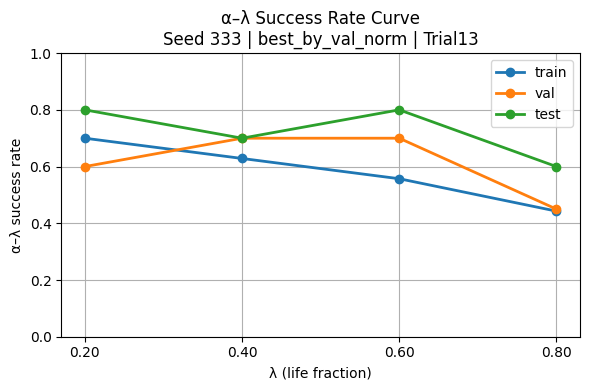

[SAVE] ./Trial13\seed_333\best_by_val_norm\alpha_lambda_eval\alpha_lambda_curve_seed333_best_by_val_norm.png


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# USER CONFIG (Trial13)
# =========================
TRIAL13_DIR = r"./Trial13"
SEED = 333
CKPT = "best_by_val_norm"   # or "last_epoch"

LAM_STRS = ["0.20", "0.40", "0.60", "0.80"]
LAM = [float(x) for x in LAM_STRS]
SPLITS_ORDER = ["train", "val", "test"]

# =========================
# Paths
# =========================
AL_DIR = os.path.join(
    TRIAL13_DIR, f"seed_{SEED}", CKPT, "alpha_lambda_eval"
)
SUMMARY_CSV = os.path.join(
    AL_DIR, f"alpha_lambda_summary_seed{SEED}_{CKPT}.csv"
)
OUT_PNG = os.path.join(
    AL_DIR, f"alpha_lambda_curve_seed{SEED}_{CKPT}.png"
)

# =========================
# Load
# =========================
if not os.path.exists(SUMMARY_CSV):
    raise FileNotFoundError(f"Not found: {SUMMARY_CSV}")

df = pd.read_csv(SUMMARY_CSV)

# =========================
# Plot
# =========================
plt.figure(figsize=(6, 4))

for split in SPLITS_ORDER:
    sub = df[df["split"] == split]
    if sub.empty:
        print(f"[SKIP] no data for split={split}")
        continue

    row = sub.iloc[0]
    rates = []
    for ls in LAM_STRS:
        v = row.get(f"rate_{ls}", np.nan)
        rates.append(float(v) if np.isfinite(v) else np.nan)

    plt.plot(
        LAM,
        rates,
        marker="o",
        linewidth=2,
        label=split
    )

plt.xticks(LAM, [f"{x:.2f}" for x in LAM])
plt.ylim(0.0, 1.0)
plt.xlabel("λ (life fraction)")
plt.ylabel("α–λ success rate")
plt.title(f"α–λ Success Rate Curve\nSeed {SEED} | {CKPT} | Trial13")
plt.grid(True)
plt.legend()
plt.tight_layout()

# =========================
# Save
# =========================
os.makedirs(os.path.dirname(OUT_PNG), exist_ok=True)
plt.savefig(OUT_PNG, dpi=200, bbox_inches="tight")
plt.show()

print(f"[SAVE] {OUT_PNG}")


In [6]:
import os
from pathlib import Path
from typing import Optional, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# USER CONFIG
# ============================================================
TRIAL_DIR = r"./Trial13"              # Trial13 폴더
SEED = 333                           # seed 선택
CKPT = "best_by_val_norm"            # "best_by_val_norm" or "last_epoch"

SPLITS = ["train", "val", "test"]    # ✅ 여러 split 한 번에

ALPHA = 0.20
SEQ_LEN = 100                        # (참고) eval 구간에서 t_s=seq_len-1을 이미 metrics가 갖고 있어 직접 쓰진 않음
LAMBDA_TO_PLOT = 0.60                # α–λ 그림에 표시할 λ

MAX_FILES = None                     # None=모두, 아니면 예: 10

# 저장 폴더 루트
OUT_ROOT = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT, "paper_figures_bookstyle")

# ============================================================
# Helpers
# ============================================================
def safe_name(s: str) -> str:
    return s.replace("/", "_").replace("\\", "_").replace(":", "_")

def load_cycle_seq_and_metrics(seed_dir: str, split: str):
    """
    Trial9가 이미 만들어 둔 파일들:
      - <split>_cycle_sequence_mean.csv
      - <split>_prognostics_metrics_per_file.csv
    """
    seq_csv = os.path.join(seed_dir, f"{split}_cycle_sequence_mean.csv")
    met_csv = os.path.join(seed_dir, f"{split}_prognostics_metrics_per_file.csv")

    if not os.path.exists(seq_csv):
        raise FileNotFoundError(f"Missing: {seq_csv}")
    if not os.path.exists(met_csv):
        raise FileNotFoundError(f"Missing: {met_csv}")

    df_seq = pd.read_csv(seq_csv)
    df_met = pd.read_csv(met_csv)
    return df_seq, df_met

def get_eval_segment(df_one_file: pd.DataFrame, t_s: int, t_e: int) -> pd.DataFrame:
    df = df_one_file.sort_values("cycle").copy()
    df = df[(df["cycle"] >= t_s) & (df["cycle"] <= t_e)].copy()
    df.reset_index(drop=True, inplace=True)
    return df

# ============================================================
# Plotters
# ============================================================
def plot_ph_alpha_absolute_band(
    df_eval: pd.DataFrame,
    file_name: str,
    alpha: float,
    out_path: str,
    ph_start: Optional[float] = None,
    title_prefix: str = "",
):
    """
    BOOK Fig.2.9(a) 스타일: PH용 α-zone은 '절대 폭(평행 밴드)'
      alphaZone = alpha * EOL_true
      zone = RUL_true ± alphaZone
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].to_numpy()
    y_true = df_eval["RUL_true"].to_numpy()
    y_pred = df_eval["RUL_pred"].to_numpy()

    last_cycle = int(df_eval["cycle"].max())
    eol_true = last_cycle + 1

    alpha_zone = alpha * float(eol_true)  # ✅ book-style 핵심 (평행 밴드)
    upper = y_true + alpha_zone
    lower = y_true - alpha_zone

    plt.figure()
    plt.plot(x, y_true, "k", label="True (cycles)")
    plt.plot(x, y_pred, "r", label="Prediction (cycles)")
    plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α-zone (±α·EOL)")
    plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α-zone (±α·EOL)")

    if ph_start is not None and np.isfinite(ph_start):
        plt.axvline(int(ph_start), color="g", linestyle="-.", label="PH start")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title_prefix} | BOOK-STYLE α+PH (absolute band)\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()

def plot_alpha_lambda_relative_band(
    df_eval: pd.DataFrame,
    file_name: str,
    alpha: float,
    lambda_to_plot: float,
    t_lambda: Optional[int],
    out_path: str,
    title_prefix: str = "",
):
    """
    BOOK Fig.2.9(b) 스타일: α–λ는 '상대 폭(수렴 밴드)'
      zone = RUL_true*(1±alpha), 그리고 t >= t_lambda 구간만 표시
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].to_numpy()
    y_true = df_eval["RUL_true"].to_numpy()
    y_pred = df_eval["RUL_pred"].to_numpy()

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.figure()
    plt.plot(x, y_true, "k", label="True (cycles)")
    plt.plot(x, y_pred, "r", label="Prediction (cycles)")

    if t_lambda is not None and np.isfinite(t_lambda):
        t_lambda = int(t_lambda)
        plt.axvline(t_lambda, color="g", linestyle=":", label=f"t_λ (λ={lambda_to_plot:.2f})")

        mask = x >= t_lambda
        if np.any(mask):
            plt.plot(x[mask], upper[mask], "b--", label=f"+{alpha:.2f} α–λ zone")
            plt.plot(x[mask], lower[mask], "b--", label=f"-{alpha:.2f} α–λ zone")
        else:
            plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α zone")
            plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α zone")
    else:
        plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α zone")
        plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α zone")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title_prefix} | BOOK-STYLE α–λ (relative band)\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()

# ============================================================
# Main (multi-split)
# ============================================================
def run_for_one_split(seed_dir: str, split: str):
    df_seq, df_met = load_cycle_seq_and_metrics(seed_dir, split)

    files = df_seq["file"].unique().tolist()
    if MAX_FILES is not None:
        files = files[:MAX_FILES]

    out_dir = os.path.join(OUT_ROOT, split)  # ✅ split별 폴더
    os.makedirs(out_dir, exist_ok=True)

    lam_key = f"t_lambda_{LAMBDA_TO_PLOT:.2f}"
    title_prefix = f"SEED {SEED} | {CKPT.upper()} | {split}"

    for f in files:
        sub = df_seq[df_seq["file"] == f].copy()
        mrow = df_met[df_met["file"] == f]
        if mrow.empty:
            continue
        mrow = mrow.iloc[0].to_dict()

        t_s = int(mrow["t_s"])
        t_e = int(mrow["t_e"])
        ph_start = mrow.get("t_PH_start", np.nan)
        t_lambda = mrow.get(lam_key, np.nan)

        df_eval = get_eval_segment(sub, t_s, t_e)
        if df_eval.empty:
            continue

        sname = safe_name(f)

        out_a = os.path.join(out_dir, f"FIG_A_BOOKSTYLE_alpha_PH__{sname}.png")
        plot_ph_alpha_absolute_band(
            df_eval=df_eval,
            file_name=f,
            alpha=ALPHA,
            out_path=out_a,
            ph_start=ph_start if np.isfinite(ph_start) else None,
            title_prefix=title_prefix,
        )

        out_b = os.path.join(out_dir, f"FIG_B_BOOKSTYLE_alpha_lambda__lam{LAMBDA_TO_PLOT:.2f}__{sname}.png")
        plot_alpha_lambda_relative_band(
            df_eval=df_eval,
            file_name=f,
            alpha=ALPHA,
            lambda_to_plot=LAMBDA_TO_PLOT,
            t_lambda=int(t_lambda) if np.isfinite(t_lambda) else None,
            out_path=out_b,
            title_prefix=title_prefix,
        )

    print(f"[{split}] DONE -> {out_dir}")

def main():
    seed_dir = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT)

    for split in SPLITS:
        run_for_one_split(seed_dir, split)

    print("\nALL DONE.")
    print("Saved under:", OUT_ROOT)

if __name__ == "__main__":
    main()


[train] DONE -> ./Trial13\seed_333\best_by_val_norm\paper_figures_bookstyle\train
[val] DONE -> ./Trial13\seed_333\best_by_val_norm\paper_figures_bookstyle\val
[test] DONE -> ./Trial13\seed_333\best_by_val_norm\paper_figures_bookstyle\test

ALL DONE.
Saved under: ./Trial13\seed_333\best_by_val_norm\paper_figures_bookstyle


In [7]:
import os
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# USER CONFIG (Trial13)
# ============================================================
TRIAL_DIR = r"./Trial13"             # ✅ Trial13 루트 폴더
SEED = 333                           # seed 선택
CKPT = "best_by_val_norm"            # "best_by_val_norm" or "last_epoch"

SPLITS = ["train", "val", "test"]    # ✅ 여러 split 한 번에

ALPHA = 0.20
LAMBDA_TO_PLOT = 0.60                # α–λ 그림에 표시할 λ
MAX_FILES = None                     # None=모두, 아니면 예: 10

# ============================================================
# Paths
# Trial13 구조:
#   ./Trial13/seed_<seed>/<ckpt>/
#       train_cycle_sequence_mean.csv
#       train_prognostics_metrics_per_file.csv
#       ...
# ============================================================
SEED_DIR = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT)

# 저장 폴더 루트 (원하면 이름 바꿔도 됨)
OUT_ROOT = os.path.join(SEED_DIR, "paper_figures_bookstyle")

# ============================================================
# Helpers
# ============================================================
def safe_name(s: str) -> str:
    return s.replace("/", "_").replace("\\", "_").replace(":", "_")


def load_cycle_seq_and_metrics(seed_dir: str, split: str):
    """
    Trial12가 만들어 둔 파일들:
      - <split>_cycle_sequence_mean.csv
      - <split>_prognostics_metrics_per_file.csv
    (Trial12 export_ckpt()가 sub_dir(=seed_dir/tag) 아래에 저장함)
    """
    seq_csv = os.path.join(seed_dir, f"{split}_cycle_sequence_mean.csv")
    met_csv = os.path.join(seed_dir, f"{split}_prognostics_metrics_per_file.csv")

    if not os.path.exists(seq_csv):
        raise FileNotFoundError(f"Missing: {seq_csv}")
    if not os.path.exists(met_csv):
        raise FileNotFoundError(f"Missing: {met_csv}")

    df_seq = pd.read_csv(seq_csv)
    df_met = pd.read_csv(met_csv)
    return df_seq, df_met


def get_eval_segment(df_one_file: pd.DataFrame, t_s: int, t_e: int) -> pd.DataFrame:
    df = df_one_file.sort_values("cycle").copy()
    df = df[(df["cycle"] >= t_s) & (df["cycle"] <= t_e)].copy()
    df.reset_index(drop=True, inplace=True)
    return df


# ============================================================
# Plotters
# ============================================================
def plot_ph_alpha_absolute_band(
    df_eval: pd.DataFrame,
    file_name: str,
    alpha: float,
    out_path: str,
    ph_start: Optional[float] = None,
    title_prefix: str = "",
):
    """
    BOOK Fig.2.9(a) 스타일: PH용 α-zone은 '절대 폭(평행 밴드)'
      alphaZone = alpha * EOL_true
      zone = RUL_true ± alphaZone
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].to_numpy()
    y_true = df_eval["RUL_true"].to_numpy()
    y_pred = df_eval["RUL_pred"].to_numpy()

    last_cycle = int(df_eval["cycle"].max())
    eol_true = last_cycle + 1

    alpha_zone = alpha * float(eol_true)  # ✅ book-style 핵심 (평행 밴드)
    upper = y_true + alpha_zone
    lower = y_true - alpha_zone

    plt.figure()
    plt.plot(x, y_true, "k", label="True (cycles)")
    plt.plot(x, y_pred, "r", label="Prediction (cycles)")
    plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α-zone (±α·EOL)")
    plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α-zone (±α·EOL)")

    if ph_start is not None and np.isfinite(ph_start):
        plt.axvline(int(ph_start), color="g", linestyle="-.", label="PH start")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title_prefix} | BOOK-STYLE α+PH (absolute band)\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()


def plot_alpha_lambda_relative_band(
    df_eval: pd.DataFrame,
    file_name: str,
    alpha: float,
    lambda_to_plot: float,
    t_lambda: Optional[int],
    out_path: str,
    title_prefix: str = "",
):
    """
    BOOK Fig.2.9(b) 스타일: α–λ는 '상대 폭(수렴 밴드)'
      zone = RUL_true*(1±alpha), 그리고 t >= t_lambda 구간만 표시
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].to_numpy()
    y_true = df_eval["RUL_true"].to_numpy()
    y_pred = df_eval["RUL_pred"].to_numpy()

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.figure()
    plt.plot(x, y_true, "k", label="True (cycles)")
    plt.plot(x, y_pred, "r", label="Prediction (cycles)")

    if t_lambda is not None and np.isfinite(t_lambda):
        t_lambda = int(t_lambda)
        plt.axvline(t_lambda, color="g", linestyle=":", label=f"t_λ (λ={lambda_to_plot:.2f})")

        mask = x >= t_lambda
        if np.any(mask):
            plt.plot(x[mask], upper[mask], "b--", label=f"+{alpha:.2f} α–λ zone")
            plt.plot(x[mask], lower[mask], "b--", label=f"-{alpha:.2f} α–λ zone")
        else:
            plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α zone")
            plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α zone")
    else:
        plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α zone")
        plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α zone")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title_prefix} | BOOK-STYLE α–λ (relative band)\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()


# ============================================================
# Main (multi-split)
# ============================================================
def run_for_one_split(seed_dir: str, split: str):
    df_seq, df_met = load_cycle_seq_and_metrics(seed_dir, split)

    files = df_seq["file"].unique().tolist()
    if MAX_FILES is not None:
        files = files[:MAX_FILES]

    out_dir = os.path.join(OUT_ROOT, split)  # ✅ split별 폴더
    os.makedirs(out_dir, exist_ok=True)

    lam_key = f"t_lambda_{LAMBDA_TO_PLOT:.2f}"
    title_prefix = f"SEED {SEED} | {CKPT.upper()} | {split} | Trial12"

    for f in files:
        sub = df_seq[df_seq["file"] == f].copy()
        mrow = df_met[df_met["file"] == f]
        if mrow.empty:
            continue
        mrow = mrow.iloc[0].to_dict()

        t_s = int(mrow["t_s"])
        t_e = int(mrow["t_e"])
        ph_start = mrow.get("t_PH_start", np.nan)
        t_lambda = mrow.get(lam_key, np.nan)

        df_eval = get_eval_segment(sub, t_s, t_e)
        if df_eval.empty:
            continue

        sname = safe_name(f)

        out_a = os.path.join(out_dir, f"FIG_A_BOOKSTYLE_alpha_PH__{sname}.png")
        plot_ph_alpha_absolute_band(
            df_eval=df_eval,
            file_name=f,
            alpha=ALPHA,
            out_path=out_a,
            ph_start=ph_start if np.isfinite(ph_start) else None,
            title_prefix=title_prefix,
        )

        out_b = os.path.join(out_dir, f"FIG_B_BOOKSTYLE_alpha_lambda__lam{LAMBDA_TO_PLOT:.2f}__{sname}.png")
        plot_alpha_lambda_relative_band(
            df_eval=df_eval,
            file_name=f,
            alpha=ALPHA,
            lambda_to_plot=LAMBDA_TO_PLOT,
            t_lambda=int(t_lambda) if np.isfinite(t_lambda) else None,
            out_path=out_b,
            title_prefix=title_prefix,
        )

    print(f"[{split}] DONE -> {out_dir}")


def main():
    if not os.path.isdir(SEED_DIR):
        raise FileNotFoundError(f"Not found: {SEED_DIR}")

    # split별 실행
    for split in SPLITS:
        run_for_one_split(SEED_DIR, split)

    print("\nALL DONE.")
    print("Saved under:", OUT_ROOT)


if __name__ == "__main__":
    main()


[train] DONE -> ./Trial13\seed_333\best_by_val_norm\paper_figures_bookstyle\train
[val] DONE -> ./Trial13\seed_333\best_by_val_norm\paper_figures_bookstyle\val
[test] DONE -> ./Trial13\seed_333\best_by_val_norm\paper_figures_bookstyle\test

ALL DONE.
Saved under: ./Trial13\seed_333\best_by_val_norm\paper_figures_bookstyle


In [8]:
# Trial 9 / 13 Comparison Summary Analyzer
# ============================================================
# Trial9 vs Trial13 COMPARISON PACK (Full Version)
# - Builds comparison tables (mean±std across seeds)
# - Win-rate (per-seed best vs last) + Trial9 vs Trial13 paired-by-seed
# - Prognostics summary: PH / CRA / Convergence + α–λ success rates
# - Optional: file-level "worst ranking" comparison (top-K hard files)
#
# Output (default):
#   ./Compare_Trial9_vs_Trial13/
#     01_seed_level_metrics_all.csv
#     02_trial_level_summary_mean_std.csv
#     03_winrate_best_vs_last.csv
#     04_trial9_vs_trial13_paired_by_seed.csv
#     05_prognostics_summary_by_trial.csv
#     06_prognostics_summary_by_trial_seed.csv
#     07_alpha_lambda_success_rates.csv
#     08_worst_files_comparison_topK.csv
#     compare_report.txt
#
# Usage:
#   1) Run Trial9 and Trial13 (seed sweep) so folders exist:
#        Trial9/seed_<seed>/best_by_val_norm/...
#        Trial13/seed_<seed>/best_by_val_norm/...
#   2) Run this script.
#
# Notes:
# - Works even if some seeds are missing (skips gracefully).
# - Uses "best_by_val_norm" and "last_epoch" (both).
# - Prognostics uses <split>_prognostics_metrics_per_file.csv
# ============================================================

import os
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
import numpy as np
import pandas as pd


# ----------------------------
# USER CONFIG
# ----------------------------
@dataclass
class Cfg:
    TRIAL9_DIR: str = r"./Trial9"
    TRIAL13_DIR: str = r"./Trial13"

    # seeds you attempted (it will skip missing)
    SEEDS: Tuple[int, ...] = (9819123, 111, 222, 333, 444)

    # compare both checkpoints
    CKPTS: Tuple[str, ...] = ("best_by_val_norm", "last_epoch")

    # which split to evaluate for prognostics
    SPLIT: str = "test"  # "train"/"val"/"test"

    # alpha-lambda keys (must match your saved csv col names)
    LAMBDAS: Tuple[float, ...] = (0.2, 0.4, 0.6, 0.8)

    # for worst-file analysis (optional)
    TOPK_WORST_FILES: int = 15

    OUT_DIR: str = r"./Compare_Trial9_vs_Trial13"


cfg = Cfg()
os.makedirs(cfg.OUT_DIR, exist_ok=True)


# ============================================================
# Helpers
# ============================================================
def _exists(p: str) -> bool:
    return os.path.exists(p)


def _read_csv_safe(path: str) -> Optional[pd.DataFrame]:
    if not _exists(path):
        return None
    try:
        return pd.read_csv(path)
    except Exception:
        return None


def _trial_seed_ckpt_dir(trial_dir: str, seed: int, ckpt: str) -> str:
    return os.path.join(trial_dir, f"seed_{seed}", ckpt)


def _metrics_summary_path(trial_dir: str, seed: int, ckpt: str) -> str:
    return os.path.join(_trial_seed_ckpt_dir(trial_dir, seed, ckpt), "metrics_summary.csv")


def _prognostics_path(trial_dir: str, seed: int, ckpt: str, split: str) -> str:
    return os.path.join(_trial_seed_ckpt_dir(trial_dir, seed, ckpt), f"{split}_prognostics_metrics_per_file.csv")


def _cycle_seq_path(trial_dir: str, seed: int, ckpt: str, split: str) -> str:
    return os.path.join(_trial_seed_ckpt_dir(trial_dir, seed, ckpt), f"{split}_cycle_sequence_mean.csv")


def _format_mean_std(series: pd.Series, digits: int = 4) -> str:
    s = pd.to_numeric(series, errors="coerce").dropna()
    if len(s) == 0:
        return "nan ± nan"
    return f"{s.mean():.{digits}f} ± {s.std(ddof=0):.{digits}f}"


def _to_num(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    return out


# ============================================================
# 1) Load seed-level metrics_summary.csv from Trial9 and Trial13
# ============================================================
def collect_seed_level_metrics(trial_name: str, trial_dir: str) -> pd.DataFrame:
    rows = []
    for seed in cfg.SEEDS:
        for ckpt in cfg.CKPTS:
            ms_path = _metrics_summary_path(trial_dir, seed, ckpt)
            df = _read_csv_safe(ms_path)
            if df is None or df.empty:
                continue

            r = df.iloc[0].to_dict()
            r["trial"] = trial_name
            r["trial_dir"] = trial_dir
            r["seed"] = int(seed)
            r["checkpoint"] = ckpt
            r["metrics_summary_path"] = ms_path
            rows.append(r)

    if not rows:
        return pd.DataFrame()

    out = pd.DataFrame(rows)

    # normalize numeric
    num_cols = [
        "train_rmse_cycles","train_mae_cycles","train_rmse_norm","train_mae_norm",
        "val_rmse_cycles","val_mae_cycles","val_rmse_norm","val_mae_norm",
        "test_rmse_cycles","test_mae_cycles","test_rmse_norm","test_mae_norm",
        "best_val_rmse_norm","stopped_epoch","feature_dim"
    ]
    out = _to_num(out, [c for c in num_cols if c in out.columns])

    return out


df9 = collect_seed_level_metrics("Trial9", cfg.TRIAL9_DIR)
df13 = collect_seed_level_metrics("Trial13", cfg.TRIAL13_DIR)

df_all = pd.concat([df9, df13], axis=0, ignore_index=True)
seed_metrics_path = os.path.join(cfg.OUT_DIR, "01_seed_level_metrics_all.csv")
df_all.to_csv(seed_metrics_path, index=False)

print("[Saved]", seed_metrics_path)


# ============================================================
# 2) Trial-level summary mean±std (across seeds), by checkpoint
# ============================================================
def build_trial_level_summary(df_all: pd.DataFrame) -> pd.DataFrame:
    if df_all.empty:
        return pd.DataFrame()

    metrics = [
        "test_rmse_cycles", "test_mae_cycles", "test_rmse_norm", "test_mae_norm",
        "val_rmse_norm", "val_rmse_cycles",
        "train_rmse_cycles", "train_rmse_norm",
    ]
    rows = []
    for trial in sorted(df_all["trial"].unique()):
        for ckpt in cfg.CKPTS:
            sub = df_all[(df_all["trial"] == trial) & (df_all["checkpoint"] == ckpt)].copy()
            if sub.empty:
                continue
            row = {"trial": trial, "checkpoint": ckpt, "n_seeds": int(sub["seed"].nunique())}
            for m in metrics:
                if m in sub.columns:
                    row[m] = _format_mean_std(sub[m], digits=4)
            rows.append(row)

    return pd.DataFrame(rows)


trial_summary = build_trial_level_summary(df_all)
trial_summary_path = os.path.join(cfg.OUT_DIR, "02_trial_level_summary_mean_std.csv")
trial_summary.to_csv(trial_summary_path, index=False)
print("[Saved]", trial_summary_path)


# ============================================================
# 3) Win-rate: best_by_val_norm vs last_epoch within each trial (per seed)
# ============================================================
def win_rate_best_vs_last(df_all: pd.DataFrame) -> pd.DataFrame:
    if df_all.empty:
        return pd.DataFrame()

    # lower is better
    metrics = ["test_rmse_cycles", "test_mae_cycles", "test_rmse_norm", "test_mae_norm"]
    rows = []

    for trial in sorted(df_all["trial"].unique()):
        for metric in metrics:
            wins_last = 0
            wins_best = 0
            ties = 0
            diffs = []

            for seed in sorted(df_all[df_all["trial"] == trial]["seed"].unique()):
                b = df_all[(df_all["trial"] == trial) & (df_all["seed"] == seed) & (df_all["checkpoint"] == "best_by_val_norm")]
                l = df_all[(df_all["trial"] == trial) & (df_all["seed"] == seed) & (df_all["checkpoint"] == "last_epoch")]
                if b.empty or l.empty:
                    continue
                bv = pd.to_numeric(b.iloc[0].get(metric, np.nan), errors="coerce")
                lv = pd.to_numeric(l.iloc[0].get(metric, np.nan), errors="coerce")
                if not np.isfinite(bv) or not np.isfinite(lv):
                    continue
                diffs.append(float(lv - bv))
                if lv < bv:
                    wins_last += 1
                elif bv < lv:
                    wins_best += 1
                else:
                    ties += 1

            rows.append({
                "trial": trial,
                "metric": metric,
                "wins_last": wins_last,
                "wins_best": wins_best,
                "ties": ties,
                "mean(last-best)": float(np.mean(diffs)) if diffs else np.nan,
                "std(last-best)": float(np.std(diffs, ddof=0)) if diffs else np.nan,
                "n_compared": int(len(diffs)),
            })

    return pd.DataFrame(rows)


wr = win_rate_best_vs_last(df_all)
wr_path = os.path.join(cfg.OUT_DIR, "03_winrate_best_vs_last.csv")
wr.to_csv(wr_path, index=False)
print("[Saved]", wr_path)


# ============================================================
# 4) Trial9 vs Trial13 paired-by-seed comparison (same seed & same ckpt)
# ============================================================
def paired_seed_comparison(df_all: pd.DataFrame) -> pd.DataFrame:
    if df_all.empty:
        return pd.DataFrame()

    metrics = ["test_rmse_cycles", "test_mae_cycles", "test_rmse_norm", "test_mae_norm"]
    rows = []

    for ckpt in cfg.CKPTS:
        for seed in cfg.SEEDS:
            a = df_all[(df_all["trial"] == "Trial9") & (df_all["checkpoint"] == ckpt) & (df_all["seed"] == seed)]
            b = df_all[(df_all["trial"] == "Trial13") & (df_all["checkpoint"] == ckpt) & (df_all["seed"] == seed)]
            if a.empty or b.empty:
                continue

            row = {"seed": int(seed), "checkpoint": ckpt}
            for m in metrics:
                av = pd.to_numeric(a.iloc[0].get(m, np.nan), errors="coerce")
                bv = pd.to_numeric(b.iloc[0].get(m, np.nan), errors="coerce")
                row[f"Trial9_{m}"] = av
                row[f"Trial13_{m}"] = bv
                row[f"delta(13-9)_{m}"] = bv - av if np.isfinite(av) and np.isfinite(bv) else np.nan
            rows.append(row)

    out = pd.DataFrame(rows)

    # also add summary rows (mean delta)
    if not out.empty:
        summary = {"seed": "MEAN", "checkpoint": "ALL"}
        for m in metrics:
            dcol = f"delta(13-9)_{m}"
            summary[dcol] = pd.to_numeric(out[dcol], errors="coerce").mean()
        out = pd.concat([out, pd.DataFrame([summary])], ignore_index=True)

    return out


paired = paired_seed_comparison(df_all)
paired_path = os.path.join(cfg.OUT_DIR, "04_trial9_vs_trial13_paired_by_seed.csv")
paired.to_csv(paired_path, index=False)
print("[Saved]", paired_path)


# ============================================================
# 5) Prognostics summary from per-file CSVs (PH/CRA/Convergence + α–λ success)
# ============================================================
def collect_prognostics(trial_name: str, trial_dir: str) -> pd.DataFrame:
    rows = []
    for seed in cfg.SEEDS:
        for ckpt in cfg.CKPTS:
            path = _prognostics_path(trial_dir, seed, ckpt, cfg.SPLIT)
            df = _read_csv_safe(path)
            if df is None or df.empty:
                continue

            df = df.copy()
            df["trial"] = trial_name
            df["seed"] = int(seed)
            df["checkpoint"] = ckpt
            df["prognostics_path"] = path

            # numeric coerce
            numeric_cols = ["PH", "CRA", "Convergence_cycles", "t_PH_start"]
            for lam in cfg.LAMBDAS:
                numeric_cols += [f"alpha_lambda_ok_{lam:.2f}", f"t_lambda_{lam:.2f}"]
            df = _to_num(df, [c for c in numeric_cols if c in df.columns])

            rows.append(df)

    if not rows:
        return pd.DataFrame()
    return pd.concat(rows, axis=0, ignore_index=True)


prog9 = collect_prognostics("Trial9", cfg.TRIAL9_DIR)
prog13 = collect_prognostics("Trial13", cfg.TRIAL13_DIR)
prog_all = pd.concat([prog9, prog13], axis=0, ignore_index=True)

prog_seed_path = os.path.join(cfg.OUT_DIR, "06_prognostics_summary_by_trial_seed.csv")
if not prog_all.empty:
    prog_all.to_csv(prog_seed_path, index=False)
    print("[Saved]", prog_seed_path)
else:
    print("[Warn] No prognostics CSVs found. Skipping prognostics summary.")


def summarize_prognostics(prog_all: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    if prog_all.empty:
        return pd.DataFrame(), pd.DataFrame()

    # Core stats (per trial & ckpt)
    core_metrics = ["PH", "CRA", "Convergence_cycles"]
    rows = []
    for trial in sorted(prog_all["trial"].unique()):
        for ckpt in cfg.CKPTS:
            sub = prog_all[(prog_all["trial"] == trial) & (prog_all["checkpoint"] == ckpt)].copy()
            if sub.empty:
                continue

            row = {
                "trial": trial,
                "checkpoint": ckpt,
                "n_files": int(sub["file"].nunique()) if "file" in sub.columns else int(len(sub)),
            }

            for m in core_metrics:
                if m in sub.columns:
                    s = pd.to_numeric(sub[m], errors="coerce")
                    row[f"{m}_mean"] = float(s.mean())
                    row[f"{m}_std"] = float(s.std(ddof=0))
                    row[f"{m}_median"] = float(s.median())
                    row[f"{m}_nan_rate"] = float(np.mean(~np.isfinite(s.values)))
            rows.append(row)

    df_core = pd.DataFrame(rows)

    # α–λ success rates (mean of 0/1)
    rows2 = []
    for trial in sorted(prog_all["trial"].unique()):
        for ckpt in cfg.CKPTS:
            sub = prog_all[(prog_all["trial"] == trial) & (prog_all["checkpoint"] == ckpt)].copy()
            if sub.empty:
                continue
            row = {"trial": trial, "checkpoint": ckpt}
            for lam in cfg.LAMBDAS:
                col = f"alpha_lambda_ok_{lam:.2f}"
                if col in sub.columns:
                    v = pd.to_numeric(sub[col], errors="coerce")
                    # success rate among non-nan
                    ok = v.dropna()
                    row[f"lambda_{lam:.2f}_success_rate"] = float(ok.mean()) if len(ok) else np.nan
                    row[f"lambda_{lam:.2f}_n"] = int(len(ok))
            rows2.append(row)

    df_lam = pd.DataFrame(rows2)
    return df_core, df_lam


df_core, df_lam = summarize_prognostics(prog_all)

core_path = os.path.join(cfg.OUT_DIR, "05_prognostics_summary_by_trial.csv")
lam_path = os.path.join(cfg.OUT_DIR, "07_alpha_lambda_success_rates.csv")
df_core.to_csv(core_path, index=False)
df_lam.to_csv(lam_path, index=False)
print("[Saved]", core_path)
print("[Saved]", lam_path)


# ============================================================
# 6) Optional: Worst files comparison (top-K by mean abs error from cycle sequence)
# ============================================================
def worst_files_from_cycle_seq(trial_name: str, trial_dir: str, seed: int, ckpt: str, split: str, topk: int) -> Optional[pd.DataFrame]:
    """
    Uses <split>_cycle_sequence_mean.csv:
      columns: file, cycle, RUL_true, RUL_pred, ...
    Build per-file MAE_cycles and return top-K worst.
    """
    path = _cycle_seq_path(trial_dir, seed, ckpt, split)
    df = _read_csv_safe(path)
    if df is None or df.empty:
        return None

    # robust numeric
    for c in ["RUL_true", "RUL_pred"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    if "file" not in df.columns or "RUL_true" not in df.columns or "RUL_pred" not in df.columns:
        return None

    df = df.dropna(subset=["file", "RUL_true", "RUL_pred"]).copy()
    if df.empty:
        return None

    df["abs_err"] = np.abs(df["RUL_pred"].values - df["RUL_true"].values)

    g = df.groupby("file", as_index=False).agg(
        mae_cycles=("abs_err", "mean"),
        rmse_cycles=("abs_err", lambda x: float(np.sqrt(np.mean(np.square(x.values))))),
        n_points=("abs_err", "count"),
    )
    g = g.sort_values("mae_cycles", ascending=False).head(int(topk)).copy()
    g["trial"] = trial_name
    g["seed"] = int(seed)
    g["checkpoint"] = ckpt
    g["cycle_seq_path"] = path
    return g


rows_worst = []
for seed in cfg.SEEDS:
    for ckpt in cfg.CKPTS:
        w9 = worst_files_from_cycle_seq("Trial9", cfg.TRIAL9_DIR, seed, ckpt, cfg.SPLIT, cfg.TOPK_WORST_FILES)
        w13 = worst_files_from_cycle_seq("Trial13", cfg.TRIAL13_DIR, seed, ckpt, cfg.SPLIT, cfg.TOPK_WORST_FILES)
        if w9 is not None:
            rows_worst.append(w9)
        if w13 is not None:
            rows_worst.append(w13)

if rows_worst:
    df_worst = pd.concat(rows_worst, axis=0, ignore_index=True)
    worst_path = os.path.join(cfg.OUT_DIR, "08_worst_files_comparison_topK.csv")
    df_worst.to_csv(worst_path, index=False)
    print("[Saved]", worst_path)
else:
    worst_path = None
    print("[Info] No cycle_sequence_mean CSVs found for worst-file analysis (optional).")


# ============================================================
# 7) Human-readable report.txt
# ============================================================
def write_report(df_all: pd.DataFrame, trial_summary: pd.DataFrame, wr: pd.DataFrame,
                 paired: pd.DataFrame, df_core: pd.DataFrame, df_lam: pd.DataFrame,
                 out_path: str) -> None:
    lines = []
    lines.append("=== Trial9 vs Trial13 Comparison Report ===\n")

    # seed-level availability
    lines.append(">> Seed-level metrics availability:")
    if df_all.empty:
        lines.append("  - No metrics_summary.csv found for either trial.")
    else:
        for trial in ["Trial9", "Trial13"]:
            sub = df_all[df_all["trial"] == trial]
            lines.append(f"  - {trial}: rows={len(sub)} (seed x ckpt), seeds={sorted(sub['seed'].unique().tolist())}")

    lines.append("\n>> Trial-level mean±std (seed aggregation):")
    if trial_summary.empty:
        lines.append("  - (none)")
    else:
        lines.append(trial_summary.to_string(index=False))

    lines.append("\n>> Win-rate (best_by_val_norm vs last_epoch) per trial:")
    if wr.empty:
        lines.append("  - (none)")
    else:
        lines.append(wr.to_string(index=False))

    lines.append("\n>> Trial9 vs Trial13 paired-by-seed deltas (13-9):")
    if paired.empty:
        lines.append("  - (none)")
    else:
        lines.append(paired.to_string(index=False))

    lines.append("\n>> Prognostics summary (PH/CRA/Convergence):")
    if df_core.empty:
        lines.append("  - (none) (missing prognostics CSVs?)")
    else:
        lines.append(df_core.to_string(index=False))

    lines.append("\n>> α–λ success rates:")
    if df_lam.empty:
        lines.append("  - (none)")
    else:
        lines.append(df_lam.to_string(index=False))

    with open(out_path, "w", encoding="utf-8") as f:
        f.write("\n".join(lines))


report_path = os.path.join(cfg.OUT_DIR, "compare_report.txt")
write_report(df_all, trial_summary, wr, paired, df_core, df_lam, report_path)
print("[Saved]", report_path)

print("\nDONE. Check:", cfg.OUT_DIR)


[Saved] ./Compare_Trial9_vs_Trial13\01_seed_level_metrics_all.csv
[Saved] ./Compare_Trial9_vs_Trial13\02_trial_level_summary_mean_std.csv
[Saved] ./Compare_Trial9_vs_Trial13\03_winrate_best_vs_last.csv
[Saved] ./Compare_Trial9_vs_Trial13\04_trial9_vs_trial13_paired_by_seed.csv
[Saved] ./Compare_Trial9_vs_Trial13\06_prognostics_summary_by_trial_seed.csv
[Saved] ./Compare_Trial9_vs_Trial13\05_prognostics_summary_by_trial.csv
[Saved] ./Compare_Trial9_vs_Trial13\07_alpha_lambda_success_rates.csv
[Saved] ./Compare_Trial9_vs_Trial13\08_worst_files_comparison_topK.csv
[Saved] ./Compare_Trial9_vs_Trial13\compare_report.txt

DONE. Check: ./Compare_Trial9_vs_Trial13


In [9]:
# Trial 12 / 13 Comparison Summary Analyzer
# ============================================================
# Trial12 vs Trial13 COMPARISON PACK (Full Version)
# - Builds comparison tables (mean±std across seeds)
# - Win-rate (per-seed best vs last) + Trial12 vs Trial13 paired-by-seed
# - Prognostics summary: PH / CRA / Convergence + α–λ success rates
# - Optional: file-level "worst ranking" comparison (top-K hard files)
#
# Output (default):
#   ./Compare_Trial12_vs_Trial13/
#     01_seed_level_metrics_all.csv
#     02_trial_level_summary_mean_std.csv
#     03_winrate_best_vs_last.csv
#     04_trial12_vs_trial13_paired_by_seed.csv
#     05_prognostics_summary_by_trial.csv
#     06_prognostics_summary_by_trial_seed.csv
#     07_alpha_lambda_success_rates.csv
#     08_worst_files_comparison_topK.csv
#     compare_report.txt
#
# Usage:
#   1) Run Trial12 and Trial13 (seed sweep) so folders exist:
#        Trial12/seed_<seed>/best_by_val_norm/...
#        Trial13/seed_<seed>/best_by_val_norm/...
#   2) Run this script.
#
# Notes:
# - Works even if some seeds are missing (skips gracefully).
# - Uses "best_by_val_norm" and "last_epoch" (both).
# - Prognostics uses <split>_prognostics_metrics_per_file.csv
# ============================================================

import os
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
import numpy as np
import pandas as pd


# ----------------------------
# USER CONFIG
# ----------------------------
@dataclass
class Cfg:
    TRIAL12_DIR: str = r"./Trial12"
    TRIAL13_DIR: str = r"./Trial13"

    # seeds you attempted (it will skip missing)
    SEEDS: Tuple[int, ...] = (9819123, 111, 222, 333, 444)

    # compare both checkpoints
    CKPTS: Tuple[str, ...] = ("best_by_val_norm", "last_epoch")

    # which split to evaluate for prognostics
    SPLIT: str = "test"  # "train"/"val"/"test"

    # alpha-lambda keys (must match your saved csv col names)
    LAMBDAS: Tuple[float, ...] = (0.2, 0.4, 0.6, 0.8)

    # for worst-file analysis (optional)
    TOPK_WORST_FILES: int = 15

    OUT_DIR: str = r"./Compare_Trial12_vs_Trial13"


cfg = Cfg()
os.makedirs(cfg.OUT_DIR, exist_ok=True)


# ============================================================
# Helpers
# ============================================================
def _exists(p: str) -> bool:
    return os.path.exists(p)


def _read_csv_safe(path: str) -> Optional[pd.DataFrame]:
    if not _exists(path):
        return None
    try:
        return pd.read_csv(path)
    except Exception:
        return None


def _trial_seed_ckpt_dir(trial_dir: str, seed: int, ckpt: str) -> str:
    return os.path.join(trial_dir, f"seed_{seed}", ckpt)


def _metrics_summary_path(trial_dir: str, seed: int, ckpt: str) -> str:
    return os.path.join(_trial_seed_ckpt_dir(trial_dir, seed, ckpt), "metrics_summary.csv")


def _prognostics_path(trial_dir: str, seed: int, ckpt: str, split: str) -> str:
    return os.path.join(_trial_seed_ckpt_dir(trial_dir, seed, ckpt), f"{split}_prognostics_metrics_per_file.csv")


def _cycle_seq_path(trial_dir: str, seed: int, ckpt: str, split: str) -> str:
    return os.path.join(_trial_seed_ckpt_dir(trial_dir, seed, ckpt), f"{split}_cycle_sequence_mean.csv")


def _format_mean_std(series: pd.Series, digits: int = 4) -> str:
    s = pd.to_numeric(series, errors="coerce").dropna()
    if len(s) == 0:
        return "nan ± nan"
    return f"{s.mean():.{digits}f} ± {s.std(ddof=0):.{digits}f}"


def _to_num(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    return out


# ============================================================
# 1) Load seed-level metrics_summary.csv from Trial12 and Trial13
# ============================================================
def collect_seed_level_metrics(trial_name: str, trial_dir: str) -> pd.DataFrame:
    rows = []
    for seed in cfg.SEEDS:
        for ckpt in cfg.CKPTS:
            ms_path = _metrics_summary_path(trial_dir, seed, ckpt)
            df = _read_csv_safe(ms_path)
            if df is None or df.empty:
                continue

            r = df.iloc[0].to_dict()
            r["trial"] = trial_name
            r["trial_dir"] = trial_dir
            r["seed"] = int(seed)
            r["checkpoint"] = ckpt
            r["metrics_summary_path"] = ms_path
            rows.append(r)

    if not rows:
        return pd.DataFrame()

    out = pd.DataFrame(rows)

    # normalize numeric
    num_cols = [
        "train_rmse_cycles","train_mae_cycles","train_rmse_norm","train_mae_norm",
        "val_rmse_cycles","val_mae_cycles","val_rmse_norm","val_mae_norm",
        "test_rmse_cycles","test_mae_cycles","test_rmse_norm","test_mae_norm",
        "best_val_rmse_norm","stopped_epoch","feature_dim"
    ]
    out = _to_num(out, [c for c in num_cols if c in out.columns])

    return out


df12 = collect_seed_level_metrics("Trial12", cfg.TRIAL12_DIR)
df13 = collect_seed_level_metrics("Trial13", cfg.TRIAL13_DIR)

df_all = pd.concat([df12, df13], axis=0, ignore_index=True)
seed_metrics_path = os.path.join(cfg.OUT_DIR, "01_seed_level_metrics_all.csv")
df_all.to_csv(seed_metrics_path, index=False)

print("[Saved]", seed_metrics_path)


# ============================================================
# 2) Trial-level summary mean±std (across seeds), by checkpoint
# ============================================================
def build_trial_level_summary(df_all: pd.DataFrame) -> pd.DataFrame:
    if df_all.empty:
        return pd.DataFrame()

    metrics = [
        "test_rmse_cycles", "test_mae_cycles", "test_rmse_norm", "test_mae_norm",
        "val_rmse_norm", "val_rmse_cycles",
        "train_rmse_cycles", "train_rmse_norm",
    ]
    rows = []
    for trial in sorted(df_all["trial"].unique()):
        for ckpt in cfg.CKPTS:
            sub = df_all[(df_all["trial"] == trial) & (df_all["checkpoint"] == ckpt)].copy()
            if sub.empty:
                continue
            row = {"trial": trial, "checkpoint": ckpt, "n_seeds": int(sub["seed"].nunique())}
            for m in metrics:
                if m in sub.columns:
                    row[m] = _format_mean_std(sub[m], digits=4)
            rows.append(row)

    return pd.DataFrame(rows)


trial_summary = build_trial_level_summary(df_all)
trial_summary_path = os.path.join(cfg.OUT_DIR, "02_trial_level_summary_mean_std.csv")
trial_summary.to_csv(trial_summary_path, index=False)
print("[Saved]", trial_summary_path)


# ============================================================
# 3) Win-rate: best_by_val_norm vs last_epoch within each trial (per seed)
# ============================================================
def win_rate_best_vs_last(df_all: pd.DataFrame) -> pd.DataFrame:
    if df_all.empty:
        return pd.DataFrame()

    # lower is better
    metrics = ["test_rmse_cycles", "test_mae_cycles", "test_rmse_norm", "test_mae_norm"]
    rows = []

    for trial in sorted(df_all["trial"].unique()):
        for metric in metrics:
            wins_last = 0
            wins_best = 0
            ties = 0
            diffs = []

            for seed in sorted(df_all[df_all["trial"] == trial]["seed"].unique()):
                b = df_all[(df_all["trial"] == trial) & (df_all["seed"] == seed) & (df_all["checkpoint"] == "best_by_val_norm")]
                l = df_all[(df_all["trial"] == trial) & (df_all["seed"] == seed) & (df_all["checkpoint"] == "last_epoch")]
                if b.empty or l.empty:
                    continue
                bv = pd.to_numeric(b.iloc[0].get(metric, np.nan), errors="coerce")
                lv = pd.to_numeric(l.iloc[0].get(metric, np.nan), errors="coerce")
                if not np.isfinite(bv) or not np.isfinite(lv):
                    continue
                diffs.append(float(lv - bv))
                if lv < bv:
                    wins_last += 1
                elif bv < lv:
                    wins_best += 1
                else:
                    ties += 1

            rows.append({
                "trial": trial,
                "metric": metric,
                "wins_last": wins_last,
                "wins_best": wins_best,
                "ties": ties,
                "mean(last-best)": float(np.mean(diffs)) if diffs else np.nan,
                "std(last-best)": float(np.std(diffs, ddof=0)) if diffs else np.nan,
                "n_compared": int(len(diffs)),
            })

    return pd.DataFrame(rows)


wr = win_rate_best_vs_last(df_all)
wr_path = os.path.join(cfg.OUT_DIR, "03_winrate_best_vs_last.csv")
wr.to_csv(wr_path, index=False)
print("[Saved]", wr_path)


# ============================================================
# 4) Trial12 vs Trial13 paired-by-seed comparison (same seed & same ckpt)
# ============================================================
def paired_seed_comparison(df_all: pd.DataFrame) -> pd.DataFrame:
    if df_all.empty:
        return pd.DataFrame()

    metrics = ["test_rmse_cycles", "test_mae_cycles", "test_rmse_norm", "test_mae_norm"]
    rows = []

    for ckpt in cfg.CKPTS:
        for seed in cfg.SEEDS:
            a = df_all[(df_all["trial"] == "Trial12") & (df_all["checkpoint"] == ckpt) & (df_all["seed"] == seed)]
            b = df_all[(df_all["trial"] == "Trial13") & (df_all["checkpoint"] == ckpt) & (df_all["seed"] == seed)]
            if a.empty or b.empty:
                continue

            row = {"seed": int(seed), "checkpoint": ckpt}
            for m in metrics:
                av = pd.to_numeric(a.iloc[0].get(m, np.nan), errors="coerce")
                bv = pd.to_numeric(b.iloc[0].get(m, np.nan), errors="coerce")
                row[f"Trial12_{m}"] = av
                row[f"Trial13_{m}"] = bv
                row[f"delta(13-12)_{m}"] = bv - av if np.isfinite(av) and np.isfinite(bv) else np.nan
            rows.append(row)

    out = pd.DataFrame(rows)

    # also add summary rows (mean delta)
    if not out.empty:
        summary = {"seed": "MEAN", "checkpoint": "ALL"}
        for m in metrics:
            dcol = f"delta(13-12)_{m}"
            summary[dcol] = pd.to_numeric(out[dcol], errors="coerce").mean()
        out = pd.concat([out, pd.DataFrame([summary])], ignore_index=True)

    return out


paired = paired_seed_comparison(df_all)
paired_path = os.path.join(cfg.OUT_DIR, "04_trial12_vs_trial13_paired_by_seed.csv")
paired.to_csv(paired_path, index=False)
print("[Saved]", paired_path)


# ============================================================
# 5) Prognostics summary from per-file CSVs (PH/CRA/Convergence + α–λ success)
# ============================================================
def collect_prognostics(trial_name: str, trial_dir: str) -> pd.DataFrame:
    rows = []
    for seed in cfg.SEEDS:
        for ckpt in cfg.CKPTS:
            path = _prognostics_path(trial_dir, seed, ckpt, cfg.SPLIT)
            df = _read_csv_safe(path)
            if df is None or df.empty:
                continue

            df = df.copy()
            df["trial"] = trial_name
            df["seed"] = int(seed)
            df["checkpoint"] = ckpt
            df["prognostics_path"] = path

            # numeric coerce
            numeric_cols = ["PH", "CRA", "Convergence_cycles", "t_PH_start"]
            for lam in cfg.LAMBDAS:
                numeric_cols += [f"alpha_lambda_ok_{lam:.2f}", f"t_lambda_{lam:.2f}"]
            df = _to_num(df, [c for c in numeric_cols if c in df.columns])

            rows.append(df)

    if not rows:
        return pd.DataFrame()
    return pd.concat(rows, axis=0, ignore_index=True)


prog12 = collect_prognostics("Trial12", cfg.TRIAL12_DIR)
prog13 = collect_prognostics("Trial13", cfg.TRIAL13_DIR)
prog_all = pd.concat([prog12, prog13], axis=0, ignore_index=True)

prog_seed_path = os.path.join(cfg.OUT_DIR, "06_prognostics_summary_by_trial_seed.csv")
if not prog_all.empty:
    prog_all.to_csv(prog_seed_path, index=False)
    print("[Saved]", prog_seed_path)
else:
    print("[Warn] No prognostics CSVs found. Skipping prognostics summary.")


def summarize_prognostics(prog_all: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    if prog_all.empty:
        return pd.DataFrame(), pd.DataFrame()

    # Core stats (per trial & ckpt)
    core_metrics = ["PH", "CRA", "Convergence_cycles"]
    rows = []
    for trial in sorted(prog_all["trial"].unique()):
        for ckpt in cfg.CKPTS:
            sub = prog_all[(prog_all["trial"] == trial) & (prog_all["checkpoint"] == ckpt)].copy()
            if sub.empty:
                continue

            row = {
                "trial": trial,
                "checkpoint": ckpt,
                "n_files": int(sub["file"].nunique()) if "file" in sub.columns else int(len(sub)),
            }

            for m in core_metrics:
                if m in sub.columns:
                    s = pd.to_numeric(sub[m], errors="coerce")
                    row[f"{m}_mean"] = float(s.mean())
                    row[f"{m}_std"] = float(s.std(ddof=0))
                    row[f"{m}_median"] = float(s.median())
                    row[f"{m}_nan_rate"] = float(np.mean(~np.isfinite(s.values)))
            rows.append(row)

    df_core = pd.DataFrame(rows)

    # α–λ success rates (mean of 0/1)
    rows2 = []
    for trial in sorted(prog_all["trial"].unique()):
        for ckpt in cfg.CKPTS:
            sub = prog_all[(prog_all["trial"] == trial) & (prog_all["checkpoint"] == ckpt)].copy()
            if sub.empty:
                continue
            row = {"trial": trial, "checkpoint": ckpt}
            for lam in cfg.LAMBDAS:
                col = f"alpha_lambda_ok_{lam:.2f}"
                if col in sub.columns:
                    v = pd.to_numeric(sub[col], errors="coerce")
                    ok = v.dropna()
                    row[f"lambda_{lam:.2f}_success_rate"] = float(ok.mean()) if len(ok) else np.nan
                    row[f"lambda_{lam:.2f}_n"] = int(len(ok))
            rows2.append(row)

    df_lam = pd.DataFrame(rows2)
    return df_core, df_lam


df_core, df_lam = summarize_prognostics(prog_all)

core_path = os.path.join(cfg.OUT_DIR, "05_prognostics_summary_by_trial.csv")
lam_path = os.path.join(cfg.OUT_DIR, "07_alpha_lambda_success_rates.csv")
df_core.to_csv(core_path, index=False)
df_lam.to_csv(lam_path, index=False)
print("[Saved]", core_path)
print("[Saved]", lam_path)


# ============================================================
# 6) Optional: Worst files comparison (top-K by mean abs error from cycle sequence)
# ============================================================
def worst_files_from_cycle_seq(trial_name: str, trial_dir: str, seed: int, ckpt: str, split: str, topk: int) -> Optional[pd.DataFrame]:
    """
    Uses <split>_cycle_sequence_mean.csv:
      columns: file, cycle, RUL_true, RUL_pred, ...
    Build per-file MAE_cycles and return top-K worst.
    """
    path = _cycle_seq_path(trial_dir, seed, ckpt, split)
    df = _read_csv_safe(path)
    if df is None or df.empty:
        return None

    for c in ["RUL_true", "RUL_pred"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    if "file" not in df.columns or "RUL_true" not in df.columns or "RUL_pred" not in df.columns:
        return None

    df = df.dropna(subset=["file", "RUL_true", "RUL_pred"]).copy()
    if df.empty:
        return None

    df["abs_err"] = np.abs(df["RUL_pred"].values - df["RUL_true"].values)

    g = df.groupby("file", as_index=False).agg(
        mae_cycles=("abs_err", "mean"),
        rmse_cycles=("abs_err", lambda x: float(np.sqrt(np.mean(np.square(x.values))))),
        n_points=("abs_err", "count"),
    )
    g = g.sort_values("mae_cycles", ascending=False).head(int(topk)).copy()
    g["trial"] = trial_name
    g["seed"] = int(seed)
    g["checkpoint"] = ckpt
    g["cycle_seq_path"] = path
    return g


rows_worst = []
for seed in cfg.SEEDS:
    for ckpt in cfg.CKPTS:
        w12 = worst_files_from_cycle_seq("Trial12", cfg.TRIAL12_DIR, seed, ckpt, cfg.SPLIT, cfg.TOPK_WORST_FILES)
        w13 = worst_files_from_cycle_seq("Trial13", cfg.TRIAL13_DIR, seed, ckpt, cfg.SPLIT, cfg.TOPK_WORST_FILES)
        if w12 is not None:
            rows_worst.append(w12)
        if w13 is not None:
            rows_worst.append(w13)

if rows_worst:
    df_worst = pd.concat(rows_worst, axis=0, ignore_index=True)
    worst_path = os.path.join(cfg.OUT_DIR, "08_worst_files_comparison_topK.csv")
    df_worst.to_csv(worst_path, index=False)
    print("[Saved]", worst_path)
else:
    worst_path = None
    print("[Info] No cycle_sequence_mean CSVs found for worst-file analysis (optional).")


# ============================================================
# 7) Human-readable report.txt
# ============================================================
def write_report(df_all: pd.DataFrame, trial_summary: pd.DataFrame, wr: pd.DataFrame,
                 paired: pd.DataFrame, df_core: pd.DataFrame, df_lam: pd.DataFrame,
                 out_path: str) -> None:
    lines = []
    lines.append("=== Trial12 vs Trial13 Comparison Report ===\n")

    lines.append(">> Seed-level metrics availability:")
    if df_all.empty:
        lines.append("  - No metrics_summary.csv found for either trial.")
    else:
        for trial in ["Trial12", "Trial13"]:
            sub = df_all[df_all["trial"] == trial]
            lines.append(f"  - {trial}: rows={len(sub)} (seed x ckpt), seeds={sorted(sub['seed'].unique().tolist())}")

    lines.append("\n>> Trial-level mean±std (seed aggregation):")
    lines.append(trial_summary.to_string(index=False) if not trial_summary.empty else "  - (none)")

    lines.append("\n>> Win-rate (best_by_val_norm vs last_epoch) per trial:")
    lines.append(wr.to_string(index=False) if not wr.empty else "  - (none)")

    lines.append("\n>> Trial12 vs Trial13 paired-by-seed deltas (13-12):")
    lines.append(paired.to_string(index=False) if not paired.empty else "  - (none)")

    lines.append("\n>> Prognostics summary (PH/CRA/Convergence):")
    lines.append(df_core.to_string(index=False) if not df_core.empty else "  - (none) (missing prognostics CSVs?)")

    lines.append("\n>> α–λ success rates:")
    lines.append(df_lam.to_string(index=False) if not df_lam.empty else "  - (none)")

    with open(out_path, "w", encoding="utf-8") as f:
        f.write("\n".join(lines))


report_path = os.path.join(cfg.OUT_DIR, "compare_report.txt")
write_report(df_all, trial_summary, wr, paired, df_core, df_lam, report_path)
print("[Saved]", report_path)

print("\nDONE. Check:", cfg.OUT_DIR)


[Saved] ./Compare_Trial12_vs_Trial13\01_seed_level_metrics_all.csv
[Saved] ./Compare_Trial12_vs_Trial13\02_trial_level_summary_mean_std.csv
[Saved] ./Compare_Trial12_vs_Trial13\03_winrate_best_vs_last.csv
[Saved] ./Compare_Trial12_vs_Trial13\04_trial12_vs_trial13_paired_by_seed.csv
[Saved] ./Compare_Trial12_vs_Trial13\06_prognostics_summary_by_trial_seed.csv
[Saved] ./Compare_Trial12_vs_Trial13\05_prognostics_summary_by_trial.csv
[Saved] ./Compare_Trial12_vs_Trial13\07_alpha_lambda_success_rates.csv
[Saved] ./Compare_Trial12_vs_Trial13\08_worst_files_comparison_topK.csv
[Saved] ./Compare_Trial12_vs_Trial13\compare_report.txt

DONE. Check: ./Compare_Trial12_vs_Trial13


In [13]:
TRIAL_DIR = "./Trial13"
SEED = 333

seed_dir = os.path.join(TRIAL_DIR, f"seed_{SEED}")

import os
import pandas as pd

print(
    pd.read_csv(
        os.path.join(seed_dir, "scaler_x_mean_std.csv")
    )["feature"].tolist()
)


['min_vce', 'delta_1', 'delta_5', 'delta_20', 'delta_50', 'ema_10', 'ema_50', 'rollstd_10', 'win_mean', 'win_std', 'win_slope']


In [15]:
# ============================================================
# Trial13 PERMUTATION IMPORTANCE PACK (Full Version)
# - Feature permutation importance (11 features)
# - Time permutation importance (permute a time index across batch)
#
# Output:
#   ./Trial13/seed_<seed>/<ckpt>/perm_importance_pack/<split>/
#     01_feature_permutation_importance.csv (+ png)
#     02_time_permutation_importance.csv    (+ png)
#     used_windows_sample.csv
# ============================================================

import os
import random
from dataclasses import dataclass
from pathlib import Path
from typing import List, Tuple, Dict, Any, Optional

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# ----------------------------
# USER CONFIG
# ----------------------------
DATA_DIR   = r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100"
TRIAL_DIR  = r"./Trial13"
SEED       = 333
CKPT_TAG   = "best_by_val_norm"   # "best_by_val_norm" or "last_epoch"
SPLIT      = "test"               # "train"/"val"/"test"

SEQ_LEN      = 100
STRIDE       = 5
PRED_HORIZON = 0

HIDDEN_SIZE = 512
NUM_LAYERS  = 2
DROPOUT     = 0.2

# permutation eval batch
BATCH_SIZE_EVAL = 256
NUM_WORKERS = 0

# subsample windows for speed (None = use all)
MAX_WINDOWS = 6000

# permutation repeats (stability)
N_REPEATS_FEATURE = 3
N_REPEATS_TIME    = 2

# metric to evaluate (cycles RMSE or norm RMSE)
METRIC = "rmse_cycles"  # "rmse_cycles" or "rmse_norm"

OUT_DIR = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT_TAG, "perm_importance_pack", SPLIT)
os.makedirs(OUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
print("out_dir:", OUT_DIR)


# ----------------------------
# FIXED feature order (MUST match scaler_x_mean_std.csv you printed)
# ----------------------------
FEATURES = [
    "min_vce",
    "delta_1", "delta_5", "delta_20", "delta_50",
    "ema_10", "ema_50",
    "rollstd_10",
    "win_mean", "win_std", "win_slope",
]
FEAT_DIM = len(FEATURES)
print("feature_dim:", FEAT_DIM)


# ============================================================
# Helpers
# ============================================================
def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def list_csv_files(data_dir: str) -> List[Path]:
    p = Path(data_dir)
    files = sorted([f for f in p.glob("*.csv") if f.is_file()])
    if len(files) == 0:
        raise FileNotFoundError(f"No CSV files found in: {data_dir}")
    return files


def read_one_csv(csv_path: Path) -> Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(csv_path, header=None)
    vce = df.iloc[:, 0].astype(np.float32).to_numpy()
    rul = df.iloc[:, 1].astype(np.float32).to_numpy()
    return vce, rul


def compute_delta(v: np.ndarray, k: int) -> np.ndarray:
    out = np.zeros_like(v, dtype=np.float32)
    if k <= 0:
        return out
    out[k:] = v[k:] - v[:-k]
    return out


def ema(v: np.ndarray, span: int) -> np.ndarray:
    # simple EMA via pandas (stable & easy)
    return pd.Series(v).ewm(span=span, adjust=False).mean().astype(np.float32).to_numpy()


def rolling_std(v: np.ndarray, w: int) -> np.ndarray:
    # rolling std (min_periods=1 to avoid NaNs)
    return pd.Series(v).rolling(window=w, min_periods=1).std().fillna(0.0).astype(np.float32).to_numpy()


def window_stats(v: np.ndarray, seq_len: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # for each t, compute stats on the last seq_len points ending at t (causal)
    # mean/std/slope (linear fit)
    T = len(v)
    win_mean = np.zeros(T, dtype=np.float32)
    win_std  = np.zeros(T, dtype=np.float32)
    win_slope = np.zeros(T, dtype=np.float32)

    for t in range(T):
        s = max(0, t - (seq_len - 1))
        wv = v[s:t+1]
        win_mean[t] = float(np.mean(wv))
        win_std[t]  = float(np.std(wv, ddof=0))
        # slope with simple least squares on index
        x = np.arange(len(wv), dtype=np.float32)
        if len(wv) >= 2:
            x_mean = float(np.mean(x))
            y_mean = float(np.mean(wv))
            num = float(np.sum((x - x_mean) * (wv - y_mean)))
            den = float(np.sum((x - x_mean) ** 2)) + 1e-12
            win_slope[t] = num / den
        else:
            win_slope[t] = 0.0

    return win_mean, win_std, win_slope


def load_scaler_from_csv(seed_dir: str) -> StandardScaler:
    path = os.path.join(seed_dir, "scaler_x_mean_std.csv")
    df = pd.read_csv(path)
    # sanity check order matches
    got = df["feature"].astype(str).tolist()
    if got != FEATURES:
        raise ValueError(
            "Feature order mismatch!\n"
            f"scaler_x_mean_std.csv: {got}\n"
            f"expected FEATURES     : {FEATURES}\n"
            "=> Trial13 feature generator order must match scaler order."
        )

    scaler = StandardScaler()
    scaler.mean_ = df["mean"].values.astype(np.float64)
    std = df["std"].values.astype(np.float64)
    scaler.var_ = (std ** 2)
    scaler.scale_ = std
    scaler.n_features_in_ = len(df)
    return scaler


def read_split_list(seed_dir: str, split: str) -> List[Path]:
    p = os.path.join(seed_dir, f"{split}_files.csv")
    names = pd.read_csv(p, header=None)[0].astype(str).tolist()
    return [Path(DATA_DIR) / n for n in names]


# ============================================================
# Dataset (rebuild Trial13 features)
# ============================================================
class Trial13WindowDataset(Dataset):
    """
    returns:
      x(seq_len, 11), y_norm(1), file, start_idx, cycle_target, y_cycles, rul0
    """
    def __init__(self, file_list: List[Path], seq_len: int, stride: int, pred_horizon: int,
                 scaler_x: StandardScaler):
        self.file_list = file_list
        self.seq_len = seq_len
        self.stride = stride
        self.pred_horizon = pred_horizon
        self.scaler_x = scaler_x

        self.series: List[Tuple[str, np.ndarray, np.ndarray, float]] = []
        for fp in self.file_list:
            vce, rul = read_one_csv(fp)
            rul0 = float(rul[0])

            # ---- build 11 features (per time index)
            d1  = compute_delta(vce, 1)
            d5  = compute_delta(vce, 5)
            d20 = compute_delta(vce, 20)
            d50 = compute_delta(vce, 50)

            e10 = ema(vce, 10)
            e50 = ema(vce, 50)

            rs10 = rolling_std(vce, 10)

            wmean, wstd, wslope = window_stats(vce, seq_len)

            x = np.stack(
                [vce, d1, d5, d20, d50, e10, e50, rs10, wmean, wstd, wslope],
                axis=1
            ).astype(np.float32)  # (T, 11)

            self.series.append((fp.name, x, rul.astype(np.float32), rul0))

        # index windows
        self.index: List[Tuple[int, int]] = []
        for fi, (_name, x, _rul, _rul0) in enumerate(self.series):
            T = x.shape[0]
            last_start = T - (seq_len + pred_horizon)
            if last_start < 0:
                continue
            for s in range(0, last_start + 1, stride):
                self.index.append((fi, s))

        if len(self.index) == 0:
            raise ValueError("No windows created. Check seq_len/pred_horizon vs file lengths.")

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx: int):
        fi, s = self.index[idx]
        name, x, rul, rul0 = self.series[fi]
        xw = x[s:s + self.seq_len, :]
        y_idx = s + self.seq_len - 1 + self.pred_horizon
        y_cycles = float(rul[y_idx])
        y_norm = np.array([y_cycles / rul0], dtype=np.float32)

        xw = self.scaler_x.transform(xw).astype(np.float32)
        cycle_target = int(s + (self.seq_len - 1) + self.pred_horizon)

        return (
            torch.from_numpy(xw),
            torch.from_numpy(y_norm),
            name,
            torch.tensor(s, dtype=torch.long),
            torch.tensor(cycle_target, dtype=torch.long),
            torch.tensor(y_cycles, dtype=torch.float32),
            torch.tensor(rul0, dtype=torch.float32),
        )


# ============================================================
# Model
# ============================================================
class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout: float):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.head(last)


@torch.no_grad()
def eval_metric(model, loader, device, metric: str) -> float:
    model.eval()
    errs_norm = []
    errs_cyc = []

    for x, y_norm, _name, _s, _cycle_target, y_cycles, rul0 in loader:  # ✅ 7개로 맞춤
        x = x.to(device)
        y_norm = y_norm.to(device)
        y_cycles = y_cycles.to(device).view(-1, 1)
        rul0 = rul0.to(device).view(-1, 1)

        pred_norm = model(x)

        err_norm = (pred_norm - y_norm).detach().cpu().numpy().reshape(-1)
        pred_cyc = (pred_norm * rul0).detach().cpu().numpy().reshape(-1)
        err_cyc  = (pred_cyc - y_cycles.detach().cpu().numpy().reshape(-1))

        errs_norm.append(err_norm)
        errs_cyc.append(err_cyc)

    if len(errs_norm) == 0:
        return float("nan")

    e_norm = np.concatenate(errs_norm)
    e_cyc  = np.concatenate(errs_cyc)

    if metric == "rmse_norm":
        return float(np.sqrt(np.mean(e_norm ** 2)))
    elif metric == "rmse_cycles":
        return float(np.sqrt(np.mean(e_cyc ** 2)))
    else:
        raise ValueError("metric must be rmse_norm or rmse_cycles")



def main():
    set_seed(0)

    seed_dir = os.path.join(TRIAL_DIR, f"seed_{SEED}")
    ckpt_path = os.path.join(seed_dir, f"{CKPT_TAG}.pt")
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Missing ckpt: {ckpt_path}")

    # load scaler + build dataset
    scaler_x = load_scaler_from_csv(seed_dir)
    files = read_split_list(seed_dir, SPLIT)

    ds = Trial13WindowDataset(files, SEQ_LEN, STRIDE, PRED_HORIZON, scaler_x=scaler_x)

    # optional subsample windows (for speed)
    if MAX_WINDOWS is not None and len(ds) > MAX_WINDOWS:
        # create a small wrapper index
        idxs = np.random.RandomState(0).choice(len(ds), size=int(MAX_WINDOWS), replace=False)
        idxs = np.sort(idxs)

        class Subset(Dataset):
            def __init__(self, base, idxs):
                self.base = base
                self.idxs = idxs
            def __len__(self): return len(self.idxs)
            def __getitem__(self, i): return self.base[int(self.idxs[i])]

        ds_used = Subset(ds, idxs)
    else:
        ds_used = ds

    loader = DataLoader(ds_used, batch_size=BATCH_SIZE_EVAL, shuffle=False, num_workers=NUM_WORKERS)

    # save which windows were used (debug)
    rows = []
    for i in range(min(len(ds_used), 2000)):
        x, y_norm, name, s, cyc, y_cyc, r0 = ds_used[i]
        rows.append({"file": str(name), "start_idx": int(s), "cycle": int(cyc), "y_true": float(y_cyc)})
    pd.DataFrame(rows).to_csv(os.path.join(OUT_DIR, "used_windows_sample.csv"), index=False)

    # build model with correct input_size=11
    model = LSTMRegressor(FEAT_DIM, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()

    base = eval_metric(model, loader, device, METRIC)
    print(f"[BASE] {METRIC} = {base:.6f}")

    # ============================================================
    # (1) Feature permutation importance
    # ============================================================
    feat_imp = []
    X_cache = []

    # cache all batches once (so repeated permutations are consistent)
    for batch in loader:
        xb = batch[0].to(device)  # (B,T,F)
        y_norm = batch[1].to(device)
        y_cyc  = batch[5].to(device)  # (B,)
        r0     = batch[6].to(device)
        X_cache.append((xb, y_norm, y_cyc, r0))

    for j, feat_name in enumerate(FEATURES):
        scores = []
        for rep in range(N_REPEATS_FEATURE):
            # evaluate with feature-j permuted across batch (keep time structure)
            errs_norm = []
            errs_cyc = []
            for xb, y_norm, y_cyc, r0 in X_cache:
                xperm = xb.clone()
                perm_idx = torch.randperm(xperm.size(0), device=device)
                xperm[:, :, j] = xperm[perm_idx, :, j]

                pred_norm = model(xperm)
                err_norm = (pred_norm - y_norm).detach().cpu().numpy().reshape(-1)

                pred_cyc = (pred_norm * r0.view(-1,1)).detach().cpu().numpy().reshape(-1)
                err_cyc  = (pred_cyc - y_cyc.detach().cpu().numpy().reshape(-1))

                errs_norm.append(err_norm)
                errs_cyc.append(err_cyc)

            e_norm = np.concatenate(errs_norm)
            e_cyc  = np.concatenate(errs_cyc)

            if METRIC == "rmse_norm":
                score = float(np.sqrt(np.mean(e_norm**2)))
            else:
                score = float(np.sqrt(np.mean(e_cyc**2)))

            scores.append(score)

        mean_score = float(np.mean(scores))
        delta = mean_score - base
        feat_imp.append({"feature": feat_name, "perm_metric_mean": mean_score, "delta(+worse)": delta})
        print(f"[FEAT] {feat_name:>10s} perm={mean_score:.6f} delta={delta:.6f}")

    df_feat = pd.DataFrame(feat_imp).sort_values("delta(+worse)", ascending=False)
    df_feat.to_csv(os.path.join(OUT_DIR, "01_feature_permutation_importance.csv"), index=False)

    plt.figure()
    plt.bar(df_feat["feature"].values, df_feat["delta(+worse)"].values)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel(f"Δ {METRIC} (permuted - base)")
    plt.title(f"Trial13 Feature Permutation Importance | {SPLIT} | {CKPT_TAG} | seed={SEED}")
    plt.grid(True)
    plt.savefig(os.path.join(OUT_DIR, "01_feature_permutation_importance.png"), dpi=200, bbox_inches="tight")
    plt.close()

    # ============================================================
    # (2) Time permutation importance (permute one time index across batch)
    # ============================================================
    time_imp = []
    for t in range(SEQ_LEN):
        scores = []
        for rep in range(N_REPEATS_TIME):
            errs_norm = []
            errs_cyc = []
            for xb, y_norm, y_cyc, r0 in X_cache:
                xperm = xb.clone()
                perm_idx = torch.randperm(xperm.size(0), device=device)
                # permute ALL features at time t across batch
                xperm[:, t, :] = xperm[perm_idx, t, :]

                pred_norm = model(xperm)
                err_norm = (pred_norm - y_norm).detach().cpu().numpy().reshape(-1)

                pred_cyc = (pred_norm * r0.view(-1,1)).detach().cpu().numpy().reshape(-1)
                err_cyc  = (pred_cyc - y_cyc.detach().cpu().numpy().reshape(-1))

                errs_norm.append(err_norm)
                errs_cyc.append(err_cyc)

            e_norm = np.concatenate(errs_norm)
            e_cyc  = np.concatenate(errs_cyc)

            if METRIC == "rmse_norm":
                score = float(np.sqrt(np.mean(e_norm**2)))
            else:
                score = float(np.sqrt(np.mean(e_cyc**2)))
            scores.append(score)

        mean_score = float(np.mean(scores))
        delta = mean_score - base
        time_imp.append({"t_in_window": t, "perm_metric_mean": mean_score, "delta(+worse)": delta})

    df_time = pd.DataFrame(time_imp).sort_values("t_in_window")
    df_time.to_csv(os.path.join(OUT_DIR, "02_time_permutation_importance.csv"), index=False)

    plt.figure()
    plt.plot(df_time["t_in_window"].values, df_time["delta(+worse)"].values)
    plt.xlabel("t in window")
    plt.ylabel(f"Δ {METRIC} (permuted - base)")
    plt.title(f"Trial13 Time Permutation Importance | {SPLIT} | {CKPT_TAG} | seed={SEED}")
    plt.grid(True)
    plt.savefig(os.path.join(OUT_DIR, "02_time_permutation_importance.png"), dpi=200, bbox_inches="tight")
    plt.close()

    print("\n[DONE] Saved to:", OUT_DIR)


if __name__ == "__main__":
    main()


device: cuda
out_dir: ./Trial13\seed_333\best_by_val_norm\perm_importance_pack\test
feature_dim: 11


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_56060\971626391.py:362: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_locat

[BASE] rmse_cycles = 1569.133789
[FEAT]    min_vce perm=1679.955526 delta=110.821737
[FEAT]    delta_1 perm=1561.225667 delta=-7.908122
[FEAT]    delta_5 perm=1579.987427 delta=10.853638
[FEAT]   delta_20 perm=1577.429769 delta=8.295980
[FEAT]   delta_50 perm=1543.012939 delta=-26.120850
[FEAT]     ema_10 perm=1679.894409 delta=110.760620
[FEAT]     ema_50 perm=1683.282430 delta=114.148641
[FEAT] rollstd_10 perm=1571.307902 delta=2.174113
[FEAT]   win_mean perm=1673.238770 delta=104.104980
[FEAT]    win_std perm=1566.012899 delta=-3.120890
[FEAT]  win_slope perm=1802.418905 delta=233.285116

[DONE] Saved to: ./Trial13\seed_333\best_by_val_norm\perm_importance_pack\test


In [16]:
# ============================================================
# Trial13 Permutation Importance Pack (FULL)
# - Feature permutation importance
# - Time permutation importance (permute time indices inside window)
#
# Outputs:
#  ./Trial13/seed_<seed>/<ckpt>/perm_importance_pack/<split>/
#    00_base_metric.txt
#    01_feature_permutation_importance.csv (+png)
#    02_time_permutation_importance.csv (+png)
# ============================================================

import os
from pathlib import Path
from typing import Dict, List, Tuple, Any, Optional

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# ----------------------------
# USER CONFIG
# ----------------------------
DATA_DIR   = r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100"
TRIAL_DIR  = r"./Trial13"
SEED       = 333
CKPT_TAG   = "best_by_val_norm"     # or "last_epoch"
SPLIT      = "test"                 # train/val/test

SEQ_LEN      = 100
STRIDE       = 5
PRED_HORIZON = 0

HIDDEN_SIZE = 512
NUM_LAYERS  = 2
DROPOUT     = 0.2

BATCH_SIZE = 512
NUM_WORKERS = 0

# permutation settings
N_SAMPLES = 2000          # evaluate on at most N windows (speed)
TIME_PERM_TRIALS = 3      # repeat time permutation to reduce randomness

# metric to evaluate (lower is better)
METRIC = "rmse_cycles"    # "mae_cycles" or "rmse_cycles"

OUT_DIR = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT_TAG, "perm_importance_pack", SPLIT)
os.makedirs(OUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
print("OUT_DIR:", OUT_DIR)


# ============================================================
# Helpers: scaler + features
# ============================================================
def load_scaler_and_features(seed_dir: str) -> Tuple[StandardScaler, List[str]]:
    path = os.path.join(seed_dir, "scaler_x_mean_std.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing scaler file: {path}")

    df = pd.read_csv(path)
    feats = df["feature"].astype(str).tolist()

    scaler = StandardScaler()
    scaler.mean_ = df["mean"].values.astype(np.float64)
    std = df["std"].values.astype(np.float64)
    scaler.var_ = (std ** 2)
    scaler.scale_ = std
    scaler.n_features_in_ = len(feats)
    return scaler, feats


def read_one_csv(csv_path: Path) -> Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(csv_path, header=None)
    vce = df.iloc[:, 0].astype(np.float32).to_numpy()
    rul = df.iloc[:, 1].astype(np.float32).to_numpy()
    return vce, rul


def compute_deltas(v: np.ndarray, ks: List[int]) -> Dict[int, np.ndarray]:
    out = {}
    for k in ks:
        d = np.zeros_like(v, dtype=np.float32)
        d[k:] = v[k:] - v[:-k]
        out[k] = d
    return out


def ema(v: np.ndarray, span: int) -> np.ndarray:
    # simple EMA (pandas-like)
    alpha = 2.0 / (span + 1.0)
    y = np.zeros_like(v, dtype=np.float32)
    y[0] = v[0]
    for i in range(1, len(v)):
        y[i] = alpha * v[i] + (1 - alpha) * y[i - 1]
    return y


def rolling_std(v: np.ndarray, win: int) -> np.ndarray:
    out = np.zeros_like(v, dtype=np.float32)
    for i in range(len(v)):
        s = max(0, i - win + 1)
        out[i] = np.std(v[s:i+1], ddof=0).astype(np.float32)
    return out


def window_stats(v_window: np.ndarray) -> Tuple[float, float, float]:
    # mean, std, slope (linear fit)
    x = np.arange(len(v_window), dtype=np.float32)
    y = v_window.astype(np.float32)
    m = float(np.mean(y))
    s = float(np.std(y, ddof=0))
    # slope via least squares
    x_mean = float(np.mean(x))
    y_mean = float(np.mean(y))
    denom = float(np.sum((x - x_mean) ** 2)) + 1e-12
    slope = float(np.sum((x - x_mean) * (y - y_mean)) / denom)
    return m, s, slope


# ============================================================
# Dataset: build the EXACT Trial13 feature set
#   feature order must match scaler_x_mean_std.csv
# ============================================================
class WindowedTrial13Dataset(Dataset):
    """
    returns a batch tuple with at least:
      x(T,F), y_norm(1), name, start_idx, cycle_target, y_cycles, rul0
    """
    def __init__(self,
                 file_list: List[Path],
                 seq_len: int,
                 stride: int,
                 pred_horizon: int,
                 scaler_x: StandardScaler,
                 feature_names: List[str]):

        self.file_list = file_list
        self.seq_len = seq_len
        self.stride = stride
        self.pred_horizon = pred_horizon
        self.scaler_x = scaler_x
        self.feature_names = feature_names

        # config inferred from names
        self.delta_ks = [1,5,20,50]
        self.ema_spans = [10,50]
        self.rollstd_win = 10

        self.series = []  # (name, X(T,F), rul(T), rul0)
        for fp in self.file_list:
            vce, rul = read_one_csv(fp)
            rul0 = float(rul[0])
            if rul0 <= 0:
                continue

            # base signals
            d = compute_deltas(vce, self.delta_ks)
            ema10 = ema(vce, 10)
            ema50 = ema(vce, 50)
            rs10 = rolling_std(vce, self.rollstd_win)

            # build per-time features first (some window stats appended per-time)
            feats_by_name = {
                "min_vce": vce,
                "delta_1": d[1],
                "delta_5": d[5],
                "delta_20": d[20],
                "delta_50": d[50],
                "ema_10": ema10,
                "ema_50": ema50,
                "rollstd_10": rs10,
            }

            # window stats features depend on window → easiest is to compute later per window
            # but we want x(T,F) per sample, so we will compute X on the fly in __getitem__
            # store raw arrays
            self.series.append((fp.name, vce, feats_by_name, rul.astype(np.float32), rul0))

        # index windows
        self.index = []
        for fi, (_name, vce, _fbn, rul, _r0) in enumerate(self.series):
            T = len(vce)
            last_start = T - (seq_len + pred_horizon)
            if last_start < 0:
                continue
            for s in range(0, last_start + 1, stride):
                self.index.append((fi, s))

        if len(self.index) == 0:
            raise ValueError("No windows created (check seq_len/stride).")

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx: int):
        fi, s = self.index[idx]
        name, vce, fbn, rul, rul0 = self.series[fi]

        y_idx = s + self.seq_len - 1 + self.pred_horizon
        y_cycles = float(rul[y_idx])
        y_norm = np.array([y_cycles / rul0], dtype=np.float32)
        cycle_target = int(y_idx)

        # window stats (computed from raw min_vce window)
        v_win = vce[s:s+self.seq_len]
        w_mean, w_std, w_slope = window_stats(v_win)

        # assemble X in feature_names order
        X = np.zeros((self.seq_len, len(self.feature_names)), dtype=np.float32)
        for j, fn in enumerate(self.feature_names):
            if fn in fbn:
                X[:, j] = fbn[fn][s:s+self.seq_len]
            elif fn == "win_mean":
                X[:, j] = w_mean
            elif fn == "win_std":
                X[:, j] = w_std
            elif fn == "win_slope":
                X[:, j] = w_slope
            else:
                raise KeyError(f"Unknown feature name: {fn}")

        # scale
        X = self.scaler_x.transform(X).astype(np.float32)

        return (
            torch.from_numpy(X),
            torch.from_numpy(y_norm),
            name,
            torch.tensor(s, dtype=torch.long),
            torch.tensor(cycle_target, dtype=torch.long),
            torch.tensor(y_cycles, dtype=torch.float32),
            torch.tensor(rul0, dtype=torch.float32),
        )


# ============================================================
# Model
# ============================================================
class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout: float):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.head(last)


# ============================================================
# Eval metric
# ============================================================
@torch.no_grad()
def eval_metric(model: nn.Module, loader: DataLoader, device, metric: str) -> float:
    model.eval()
    abs_errs = []
    sq_errs = []

    for batch in loader:
        x = batch[0].to(device)
        y_norm = batch[1].to(device)
        y_cycles = batch[-2].to(device).view(-1, 1)
        rul0 = batch[-1].to(device).view(-1, 1)

        pred_norm = model(x)
        pred_cycles = pred_norm * rul0

        err = (pred_cycles - y_cycles).detach().cpu().numpy().reshape(-1)
        abs_errs.append(np.abs(err))
        sq_errs.append(err**2)

    abs_err = np.concatenate(abs_errs) if abs_errs else np.array([], dtype=np.float32)
    sq_err = np.concatenate(sq_errs) if sq_errs else np.array([], dtype=np.float32)

    if metric == "mae_cycles":
        return float(np.mean(abs_err)) if len(abs_err) else np.nan
    if metric == "rmse_cycles":
        return float(np.sqrt(np.mean(sq_err))) if len(sq_err) else np.nan
    raise ValueError("metric must be 'mae_cycles' or 'rmse_cycles'")


def subsample_loader(loader: DataLoader, max_n: int) -> DataLoader:
    # easiest: just stop early in evaluation by wrapping; but we need same loader object
    # We'll instead create a new loader with a Subset of dataset indices.
    ds = loader.dataset
    n = len(ds)
    if n <= max_n:
        return loader
    idx = np.random.RandomState(0).choice(n, size=max_n, replace=False)
    subset = torch.utils.data.Subset(ds, idx.tolist())
    return DataLoader(subset, batch_size=loader.batch_size, shuffle=False, num_workers=0)


# ============================================================
# Permutation importance
# ============================================================
@torch.no_grad()
def feature_permutation_importance(model, loader, device, feature_names: List[str], base: float) -> pd.DataFrame:
    ds = loader.dataset
    F = len(feature_names)

    rows = []
    for fj in range(F):
        metric_vals = []

        for batch in loader:
            x = batch[0].to(device)           # (B,T,F)
            y_norm = batch[1].to(device)
            y_cycles = batch[-2].to(device).view(-1, 1)
            rul0 = batch[-1].to(device).view(-1, 1)

            # permute feature fj across batch (keeps time structure)
            xp = x.clone()
            perm = torch.randperm(x.size(0), device=device)
            xp[:, :, fj] = xp[perm, :, fj]

            pred_norm = model(xp)
            pred_cycles = pred_norm * rul0
            err = (pred_cycles - y_cycles).detach().cpu().numpy().reshape(-1)

            if METRIC == "mae_cycles":
                metric_vals.append(float(np.mean(np.abs(err))))
            else:
                metric_vals.append(float(np.sqrt(np.mean(err**2))))

        perm_metric = float(np.mean(metric_vals)) if metric_vals else np.nan
        rows.append({
            "feature": feature_names[fj],
            "perm_metric_mean": perm_metric,
            "delta(+worse)": perm_metric - base,
        })

    df = pd.DataFrame(rows).sort_values("delta(+worse)", ascending=False).reset_index(drop=True)
    return df


@torch.no_grad()
def time_permutation_importance(model, loader, device, base: float, trials: int = 3) -> pd.DataFrame:
    # permute time order inside window (same permutation for all features)
    T = SEQ_LEN
    deltas = []

    for t in range(T):
        # here: we disrupt one timestep position by shuffling its values with another random timestep
        # simpler & stable: shuffle the values at time t across batch (keeps other times intact)
        trial_vals = []
        for _ in range(trials):
            metric_vals = []
            for batch in loader:
                x = batch[0].to(device)  # (B,T,F)
                y_cycles = batch[-2].to(device).view(-1, 1)
                rul0 = batch[-1].to(device).view(-1, 1)

                xp = x.clone()
                perm = torch.randperm(x.size(0), device=device)
                xp[:, t, :] = xp[perm, t, :]   # shuffle that timestep across batch

                pred_norm = model(xp)
                pred_cycles = pred_norm * rul0
                err = (pred_cycles - y_cycles).detach().cpu().numpy().reshape(-1)

                if METRIC == "mae_cycles":
                    metric_vals.append(float(np.mean(np.abs(err))))
                else:
                    metric_vals.append(float(np.sqrt(np.mean(err**2))))

            trial_vals.append(float(np.mean(metric_vals)) if metric_vals else np.nan)

        perm_metric = float(np.nanmean(trial_vals))
        deltas.append(perm_metric - base)

    df = pd.DataFrame({
        "t_in_window": np.arange(T),
        "perm_metric_mean": (np.array(deltas) + base),
        "delta(+worse)": np.array(deltas),
    }).sort_values("delta(+worse)", ascending=False).reset_index(drop=True)
    return df


def save_bar(df: pd.DataFrame, xcol: str, ycol: str, out_png: str, title: str, topk: Optional[int] = None):
    os.makedirs(os.path.dirname(out_png), exist_ok=True)
    d = df.copy()
    if topk is not None:
        d = d.head(topk)
    plt.figure(figsize=(10, 4))
    plt.bar(d[xcol].astype(str).values, d[ycol].values)
    plt.xticks(rotation=45, ha="right")
    plt.title(title)
    plt.ylabel(ycol)
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()


# ============================================================
# MAIN
# ============================================================
def main():
    seed_dir = os.path.join(TRIAL_DIR, f"seed_{SEED}")
    ckpt_path = os.path.join(seed_dir, f"{CKPT_TAG}.pt")
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Missing ckpt: {ckpt_path}")

    scaler_x, feature_names = load_scaler_and_features(seed_dir)
    input_dim = len(feature_names)
    print("feature_dim:", input_dim)
    print("features:", feature_names)

    # split file list
    split_list_path = os.path.join(seed_dir, f"{SPLIT}_files.csv")
    names = pd.read_csv(split_list_path, header=None)[0].astype(str).tolist()
    file_list = [Path(DATA_DIR) / n for n in names]

    ds = WindowedTrial13Dataset(
        file_list=file_list,
        seq_len=SEQ_LEN,
        stride=STRIDE,
        pred_horizon=PRED_HORIZON,
        scaler_x=scaler_x,
        feature_names=feature_names,
    )
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    loader = subsample_loader(loader, N_SAMPLES)

    # model
    model = LSTMRegressor(input_dim, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()

    # baseline metric
    base = eval_metric(model, loader, device, METRIC)
    with open(os.path.join(OUT_DIR, "00_base_metric.txt"), "w", encoding="utf-8") as f:
        f.write(f"METRIC={METRIC}\nBASE={base:.6f}\n")
    print(f"[BASE] {METRIC} = {base:.6f}")

    # (1) Feature permutation
    df_feat = feature_permutation_importance(model, loader, device, feature_names, base)
    df_feat.to_csv(os.path.join(OUT_DIR, "01_feature_permutation_importance.csv"), index=False)
    save_bar(
        df_feat, "feature", "delta(+worse)",
        os.path.join(OUT_DIR, "01_feature_permutation_importance.png"),
        title=f"Feature Permutation Importance (delta worse) | {SPLIT} | {CKPT_TAG}",
        topk=None
    )
    print("[Saved] 01_feature_permutation_importance.csv (+png)")

    # (2) Time permutation
    df_time = time_permutation_importance(model, loader, device, base, trials=TIME_PERM_TRIALS)
    df_time.to_csv(os.path.join(OUT_DIR, "02_time_permutation_importance.csv"), index=False)
    save_bar(
        df_time, "t_in_window", "delta(+worse)",
        os.path.join(OUT_DIR, "02_time_permutation_importance.png"),
        title=f"Time Permutation Importance (delta worse) | {SPLIT} | {CKPT_TAG} (top time steps)",
        topk=30
    )
    print("[Saved] 02_time_permutation_importance.csv (+png)")

    print("\n[DONE] Saved to:", OUT_DIR)


if __name__ == "__main__":
    main()


device: cuda
OUT_DIR: ./Trial13\seed_333\best_by_val_norm\perm_importance_pack\test
feature_dim: 11
features: ['min_vce', 'delta_1', 'delta_5', 'delta_20', 'delta_50', 'ema_10', 'ema_50', 'rollstd_10', 'win_mean', 'win_std', 'win_slope']


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_56060\1962916574.py:448: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[BASE] rmse_cycles = 1569.555786
[Saved] 01_feature_permutation_importance.csv (+png)
[Saved] 02_time_permutation_importance.csv (+png)

[DONE] Saved to: ./Trial13\seed_333\best_by_val_norm\perm_importance_pack\test
